# Исследование для интернет-магазина "Стримчик"

**Цель исследования** - на данных доступных из открытых источников о продажах игр, оценок пользователей и экспертов, жанров и платформ найдем определяющие успешность игры закономерности.

Результаты исследования позволят сделать ставку на потенциально популярный продукт и спланировать рекламные кампании.

**Ход исследования**

 1. Обзор данных
 2. Предобработка данных
 - оценка качества данных (проверка на ошибки),
 - замена типов данных, 
 - обработка пропусков
 
 3. Исследовательский анализ данных
 - 3.1 Количество игр, выпускаемое в разные годы
 - 3.2 Продажи игр для разных платформ
 - 3.3 Актуальный период
 - 3.4 Потенциально прибыльные платформы
 - 3.5 Распределение продаж по платформам
 - 3.6 Влияние отзывов пользователей и критиков на продажи внутри платформ
 - 3.7 Распределение игр по жанрам
 
 
 4. Портрет пользователя каждого региона
 - 4.1 Топ-5 самых популярных жанров
 - 4.2 Топ-5 самых популярных платформ
 - 4.3 Влияние рейтинга ESRB на продажи в отдельных регионах
 
 5. Статистический анализ данных. Проверка гипотез
 - 5.1 Средние пользовательские рейтинги платформ Xbox One и PC одинаковые
 - 5.2 Средние пользовательские рейтинги жанров Action и Sports разные
 
 6. Результаты исследования

## Общая информация <a id='intro'></a>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
data = pd.read_csv('games.csv')

In [3]:
data.head()

,Name,Platform,Year_of_Release,Genre,NA_sales,EU_sales,JP_sales,Other_sales,Critic_Score,User_Score,Rating
0,Wii Sports,Wii,2006.0,Sports,41.36,28.96,3.77,8.45,76.0,8,E
1,Super Mario Bros.,NES,1985.0,Platform,29.08,3.58,6.81,0.77,NaN,NaN,NaN
2,Mario Kart Wii,Wii,2008.0,Racing,15.68,12.76,3.79,3.29,82.0,8.3,E
3,Wii Sports Resort,Wii,2009.0,Sports,15.61,10.93,3.28,2.95,80.0,8,E
4,Pokemon Red/Pokemon Blue,GB,1996.0,Role-Playing,11.27,8.89,10.22,1.00,NaN,NaN,NaN


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16715 entries, 0 to 16714
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Name             16713 non-null  object 
 1   Platform         16715 non-null  object 
 2   Year_of_Release  16446 non-null  float64
 3   Genre            16713 non-null  object 
 4   NA_sales         16715 non-null  float64
 5   EU_sales         16715 non-null  float64
 6   JP_sales         16715 non-null  float64
 7   Other_sales      16715 non-null  float64
 8   Critic_Score     8137 non-null   float64
 9   User_Score       10014 non-null  object 
 10  Rating           9949 non-null   object 
dtypes: float64(6), object(5)
memory usage: 1.4+ MB


Согласно документации к данным:
* `Name` — название игры
* `Platform` — платформа
* `Year_of_Release` — год выпуска
* `Genre` — жанр игры
* `NA_sales` — продажи в Северной Америке (миллионы проданных копий)
* `EU_sales` — продажи в Европе (миллионы проданных копий)
* `JP_sales` — продажи в Японии (миллионы проданных копий)
* `Other_sales` — продажи в других странах (миллионы проданных копий)
* `Critic_Score` — оценка критиков (максимум 100)
* `User_Score` — оценка пользователей (максимум 10)
* `Rating` — рейтинг от организации ESRB (англ. Entertainment Software Rating Board). Эта ассоциация определяет рейтинг компьютерных игр и присваивает им подходящую возрастную категорию.

## Предобработка данных <a id='intro2'></a>

Приведем названия столбцов к нижнему регистру

In [5]:
data.columns = data.columns.str.lower()

Определим в каких столбцах есть пропущенные значения:

In [6]:
data.isna().sum()

name                  2
platform              0
year_of_release     269
genre                 2
na_sales              0
eu_sales              0
jp_sales              0
other_sales           0
critic_score       8578
user_score         6701
rating             6766
dtype: int64

Также определим долю пропущенных значений для каждого из столбцов, это поможет принять решение об удалении, замене или игнорировании пропусков:

In [7]:
pd.DataFrame(round(data.isna().mean()*100,1)).style.background_gradient('coolwarm')

,0
name,0.000000
platform,0.000000
year_of_release,1.600000
genre,0.000000
na_sales,0.000000
eu_sales,0.000000
jp_sales,0.000000
other_sales,0.000000
critic_score,51.300000
user_score,40.100000


Удалим строки с пропущенными значениями в столбце `name`, по этому столбцу нельзя логически подобрать пропущенное значение, оставлять это значение пустым тоже неверно, потому что непонятно о какой игре идет речь. Возможно при внесении данных эти значения забыли указать, либо на тот момент еще не было утверждено окончательное название видеоигры.

In [8]:
data[data['name'].isna()]

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
659,NaN,GEN,1993.0,NaN,1.78,0.53,0.00,0.08,NaN,NaN,NaN
14244,NaN,GEN,1993.0,NaN,0.00,0.00,0.03,0.00,NaN,NaN,NaN


В строках с пропущенными названиями игр пропущен и их жанр (столбец `genre`), к тому же количество пропусков по этим столбцам совпадает, поэтому при удалении строк с пропущенными значениями в столбце `name` мы избавимся от пропусков и в столбце `genre`. Вероятнее всего на момент внесения данных жанр видеоигры еще не был определен.

In [9]:
data = data.dropna(subset=['name'])

Удалим из таблицы строки с пропущенными значениями в столбце `year_of_release`, т.к. по этому столбцу нельзя логически подобрать пропущенное значение. Доля пропусков менее 2%, мы не потеряем много данных, но при этом сэкономим время. Вероятнее всего при внесении данных точная дата релиза игры еще не была определена, либо эту информацию просто забыли внести.

In [10]:
data = data.dropna(subset=['year_of_release'])

Изменим типы данных в столбцах с годом выпуска (нелогично что год вещественное число):

In [11]:
data['year_of_release'] = data['year_of_release'].astype('int')

Рассмотрим подробнее столбец `user_score`, в котором доля пропущенных значений составляет более 40%.

In [12]:
data['user_score'].unique()

array(['8', nan, '8.3', '8.5', '6.6', '8.4', '8.6', '7.7', '6.3', '7.4',
       '8.2', '9', '7.9', '8.1', '8.7', '7.1', '3.4', '5.3', '4.8', '3.2',
       '8.9', '6.4', '7.8', '7.5', '2.6', '7.2', '9.2', '7', '7.3', '4.3',
       '7.6', '5.7', '5', '9.1', '6.5', 'tbd', '8.8', '6.9', '9.4', '6.8',
       '6.1', '6.7', '5.4', '4', '4.9', '4.5', '9.3', '6.2', '4.2', '6',
       '3.7', '4.1', '5.8', '5.6', '5.5', '4.4', '4.6', '5.9', '3.9',
       '3.1', '2.9', '5.2', '3.3', '4.7', '5.1', '3.5', '2.5', '1.9', '3',
       '2.7', '2.2', '2', '9.5', '2.1', '3.6', '2.8', '1.8', '3.8', '0',
       '1.6', '9.6', '2.4', '1.7', '1.1', '0.3', '1.5', '0.7', '1.2',
       '2.3', '0.5', '1.3', '0.2', '0.6', '1.4', '0.9', '1', '9.7'],
      dtype=object)

Обратим внимание на значение "tbd" (именно оно дает тип данных по этому столцу object), найдем количество строк с таким значением:

In [13]:
data['user_score'].value_counts()['tbd']

2376

Аббревиатура "tbd" часто используется в сфере компьютерных игр и рассшифровывается как to be determined с англ. "будет определено", опираясь на эту информацию можно предположить, что такой ответ выбирают пользователи, которые еще не приняли решение как оценить игру, что аналогично пропуску. Примем значение "tbd" пустым и заменим его на NaN.

In [14]:
data['user_score'] = data['user_score'].replace('tbd', np.nan)

Изменим тип данных в этом столбце (судя по описанию и содержанию столбца тип данных должен быть float):

In [15]:
data['user_score'] = data['user_score'].astype('float')

Также рассмотрим столбцы `critic_score`, `user_score` и `rating` в совокупности, определим количество строк, где значения пропущены по всем трем столбцам:

In [16]:
data['name'][data['critic_score'].isna() & data['user_score'].isna() & data['rating'].isna()].count()

6580

6580 строк с одновременно пропущенными значениями в столбцах с оценкой пользователей, критиков и возрастным рейтингом. Возможно это связано с возрастным рейтингом, дело в том, что ESRB (Entertainment Software Rating Board) - ассоциация, определяющей возрастной рейтинг компьютерных видеоигр в **США и Канаде**, и например авторы игр для локального рынка других стран не заинтересованы в получение рейтинга ESRB и не отправляют свой продукт на оценку.

Тем не менее значения по этим стобцам не удастся подобрать логически, при этом удалить строки с пропущенными значениями будет неверно, т.к. в таком случае мы потеряем большой объем данных, который могли бы использовать для дальнейшего анализа. 

Заменим пропущенные значения в столбце`rating` значениями "unknown". Пропущенные значения в столбцах `critic_score`, `user_score` оставим пропущенными, нам важно сохранить вещественный тип данных в этих столбцах.


In [17]:
data['rating'] = data['rating'].replace(np.nan, 'unknown')

Рассмотрим подробнее столбец `rating`.

In [18]:
data['rating'].unique()

array(['E', 'unknown', 'M', 'T', 'E10+', 'K-A', 'AO', 'EC', 'RP'],
      dtype=object)

Согласно данным ESRB знаки рейтинга имеют следующее описание:
* «EC» (Early childhood) — «Для детей младшего возраста»
* «E» (Everyone) — «Для всех»
* «E10+» (Everyone 10 and older) — «Для всех от 10 лет и старше»
* «T» (Teen) — «Подросткам»
* «M» (Mature) — «Для взрослых»
* «AO» (Adults Only 18+) — «Только для взрослых»
* «RP» (Rating Pending) — «Рейтинг ожидается»

Значение «K-A» (Kids to adults) устаревший знак «E10+», поэтому заменим устаревшее значение новым.

In [19]:
data['rating'] = data['rating'].replace('K-A', 'E10+')

Проверим датасет на наличие явных дубликатов:     

In [20]:
data.duplicated().sum()

0

Явных дубликатов нет.

Добавим новую метрику в наши данные, столбец `total_sales` - суммарные продажи во всех регионах.

In [21]:
data['total_sales'] = data[['na_sales','eu_sales','jp_sales', 'other_sales']].sum(axis = 1)

In [22]:
data.to_csv('games_for_db.csv', index=False)

## Исследовательский анализ данных <a id='intro3'></a>

### Количество игр, выпускаемое в разные годы<a id='intro3.1'></a>

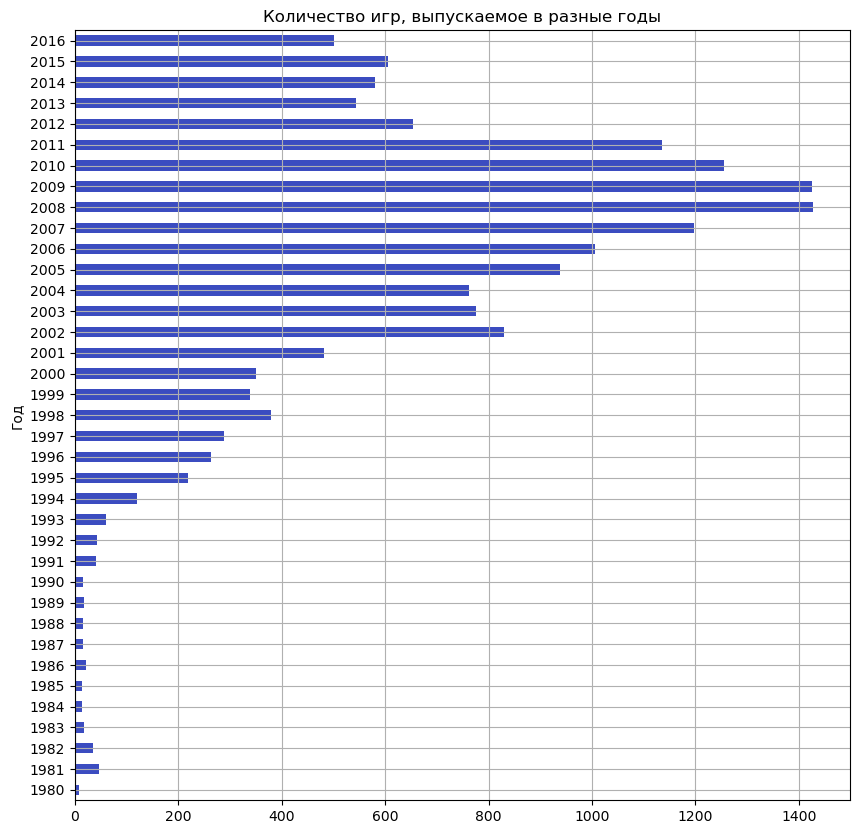

In [23]:
(data.groupby('year_of_release')['year_of_release'].agg('count')
 .plot(grid=True, figsize=(10, 10), kind='barh', cmap='coolwarm', 
      title= 'Количество игр, выпускаемое в разные годы',
      xlabel='Год',
      ylabel='Количество игр') 
);

Данные в нашем датасете берут свое начало с 1980-го года, этот характерный период для индустрии видеоигр. В это время видеоигры пришли в домашние компьютеры и вплоть до 90-х годов характерных изменений в количестве выпускаемых видеоигр не наблюдается, 90-е годы принесли ряд технологических достижений (3D революция, компакт диски, интернет и т.д.), которые существенно повлияли на развитие индустрии и соответственно на количество выпускаемых игр. Как видно по графику, начиная с 1990-го года количество игр, выпускаемых в год, в основном увеличивалось, пик приходится на 2009, 2008 год, после наблюдается спад.    

### Продажи игр для разных платформ 

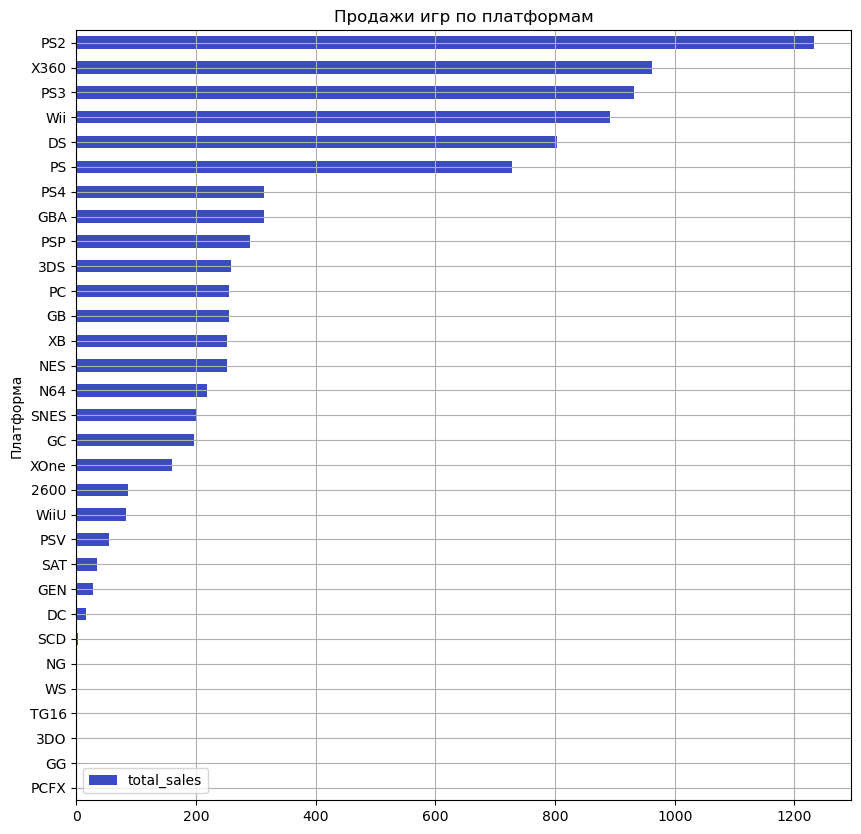

In [24]:
(data.pivot_table(
    index='platform', 
    values='total_sales',
    aggfunc='sum').sort_values(
    by='total_sales', ascending=True)
 .plot(grid=True, figsize=(10, 10), kind='barh', cmap='coolwarm', 
      title= 'Продажи игр по платформам',
      xlabel='Платформа',
      ylabel='Продажи') 
);

Рассмотрим платформы суммарные продажи на которых превысили 800 млн копий видеоигр. К таким платформам относятся PS2, X360, PS3, Wii. Определим их жизненные циклы: рассмотрим как менялись продажи видеоигр внутри платформ с момента появления платформы до ее устаревания.

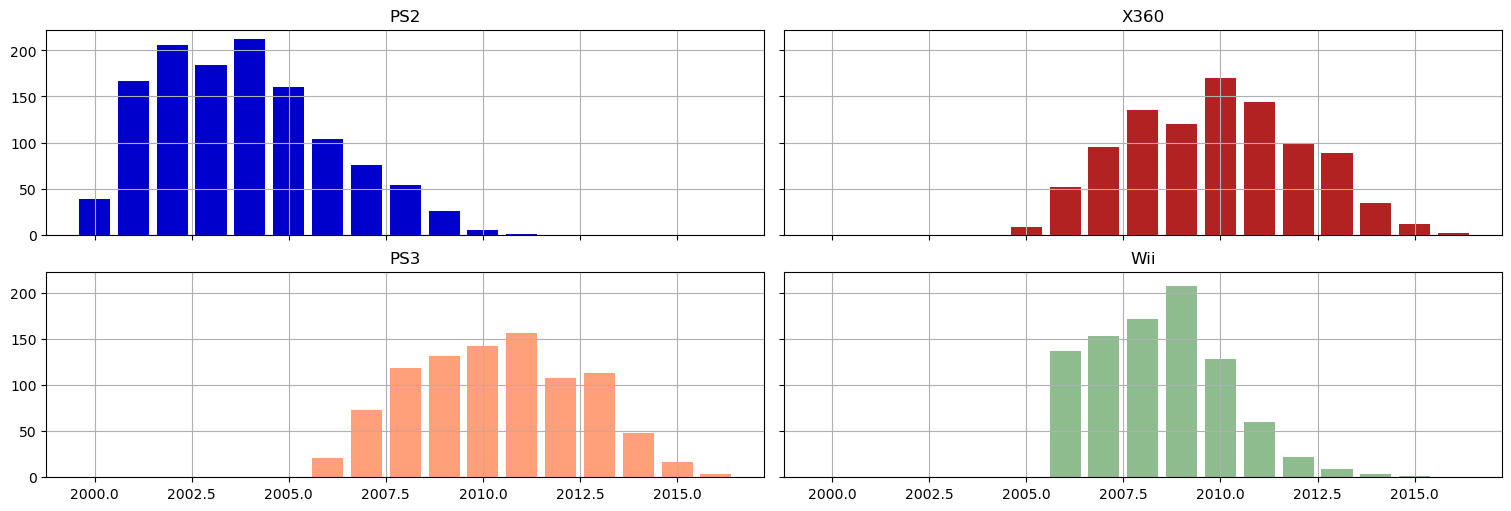

In [25]:
pl1 = data.query('platform == "PS2"').pivot_table(index='year_of_release', values='total_sales', aggfunc='sum')
pl2 = data.query('platform == "X360"').pivot_table(index='year_of_release', values='total_sales', aggfunc='sum')
pl3 = data.query('platform == "PS3"').pivot_table(index='year_of_release', values='total_sales', aggfunc='sum')
pl4 = data.query('platform == "Wii"').pivot_table(index='year_of_release', values='total_sales', aggfunc='sum')
    
fig, axs = plt.subplots(2, 2, figsize=(15, 5), sharey=True, constrained_layout=True, sharex=True)
 
axs[0, 0].bar(pl1.index, pl1['total_sales'], color='#0000CD')
axs[0, 0].set_title('PS2')
axs[0, 0].grid(True)

axs[0, 1].bar(pl2.index, pl2['total_sales'], color='#B22222')
axs[0, 1].set_title('X360')
axs[0, 1].grid(True)

axs[1, 0].bar(pl3.index, pl3['total_sales'], color='#FFA07A')
axs[1, 0].set_title('PS3')
axs[1, 0].grid(True)

axs[1, 1].bar(pl4.index, pl4['total_sales'], color='#8FBC8F')
axs[1, 1].set_title('Wii')
axs[1, 1].grid(True)


Как можно увидеть на графиках **жизненный цикл платформы в среднем составляет 10 лет**, за это время платформа появляется, набирает популярность и постепенно угасает (устаревает). Стоит обратить внимание на различное количество продаж в год появления платформы, так например у платформы  Nintendo Wii заметен весьма яркий старт (более 120 млн копий продаж в год появления платформы). При этом резкий спад платформы может произойти буквально за 3 года: продажи видеоигр для платформ сокращаются в среднем в 3 раза в течение 3-х лет после пика продаж.

Опираясь на полученные данные примем за актуальный период - 3-х летний период продаж.

### Актуальный период

Для дальнейшего исследования возьмем выборку за последние 3 года, соответственно в него войдут 2014, 2015 и 2016 года.

In [26]:
data_actual = data.query('year_of_release >= 2014')

### Определение потенциально прибыльных платформ

Рассмотрим суммарные продажи для всех платформ за актуальный период:

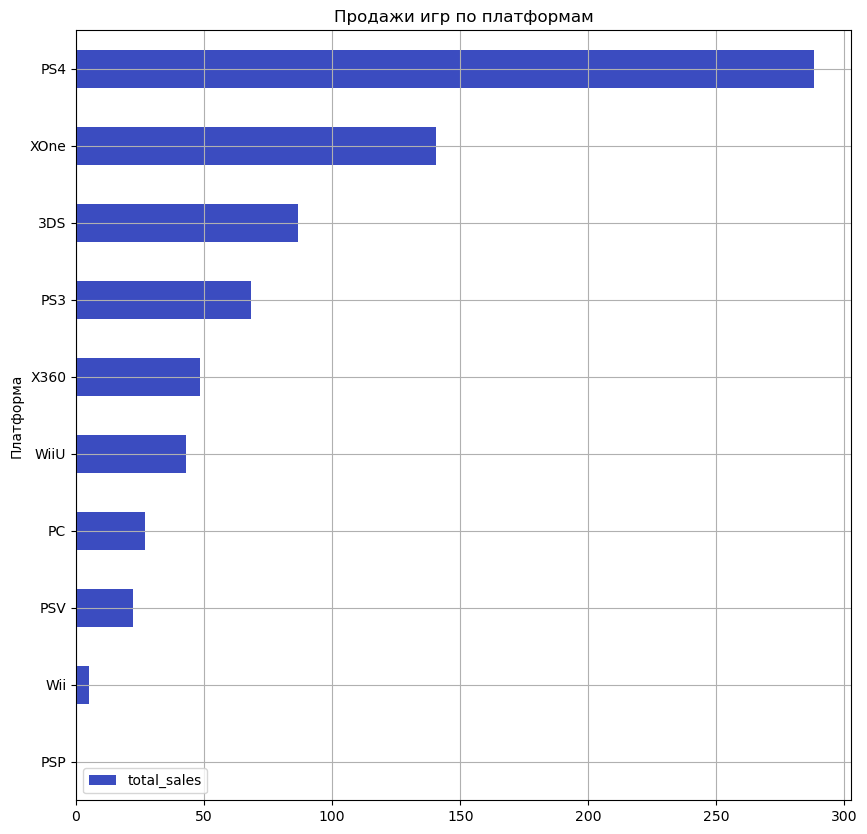

In [27]:
(data_actual.pivot_table(
    index='platform', 
    values='total_sales',
    aggfunc='sum').sort_values(
    by='total_sales', ascending=True)
 .plot(grid=True, figsize=(10, 10), kind='barh', cmap='coolwarm', 
      title= 'Продажи игр по платформам',
      xlabel='Платформа',
      ylabel='Продажи') 
);

Рассмотрим как менялись продажи видеоигр для топ-5 по продажам платформ в течение актуального периода (определим фазу жизненного цикла платформы).

PS4
XOne
3DS
PS3
X360
WiiU


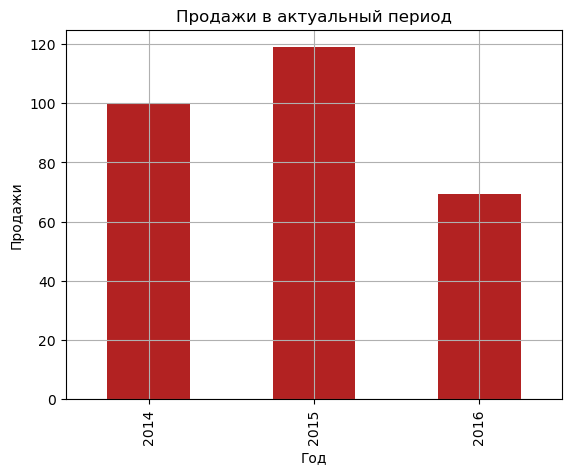

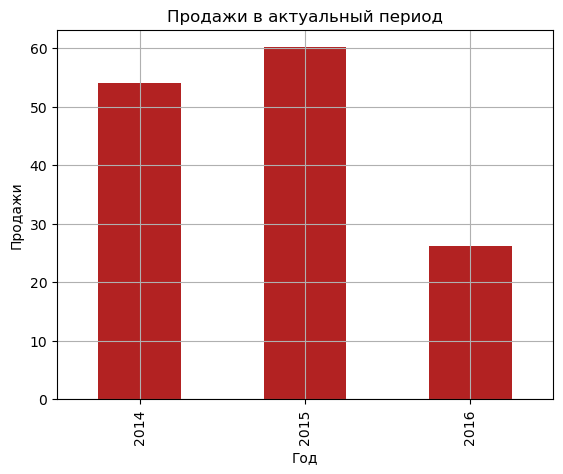

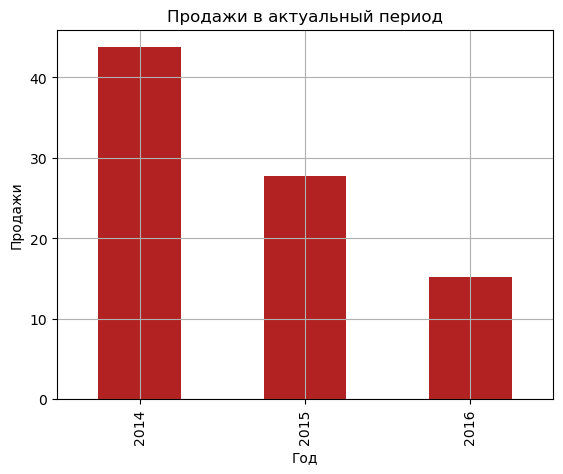

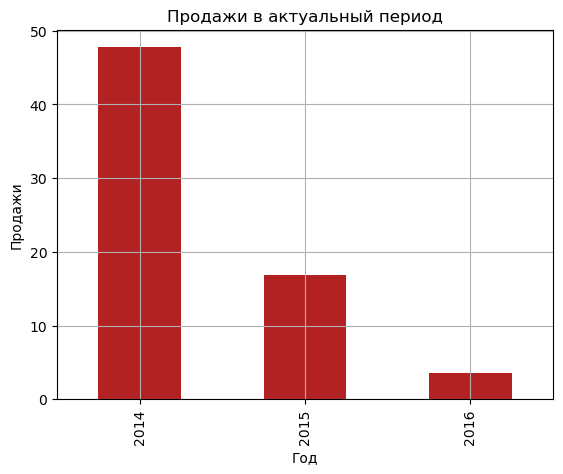

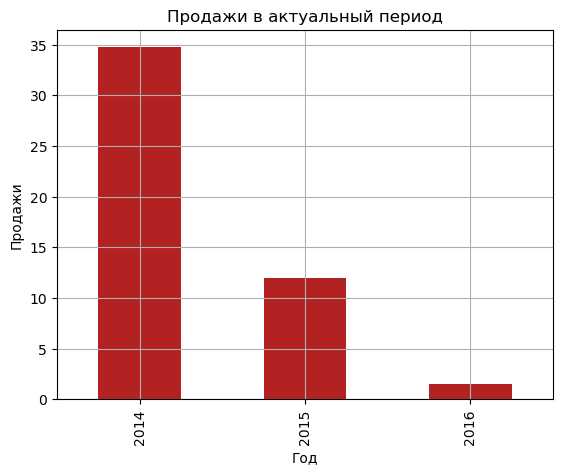

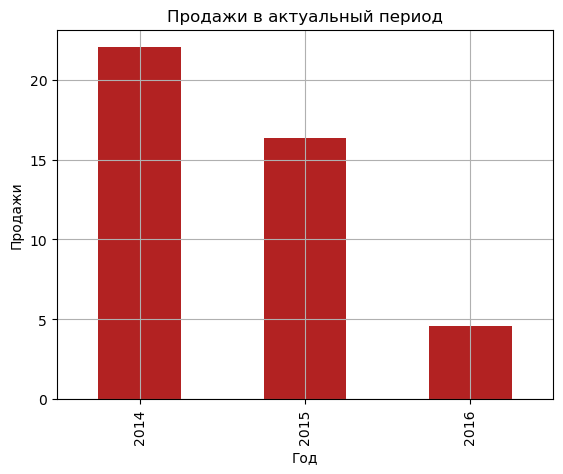

In [28]:
platform_actual = (
    data_actual
    .pivot_table(index='platform', values='total_sales', aggfunc='sum')
    .sort_values('total_sales', ascending=False)
)

for platform in platform_actual.index[:6]:
    print(platform)
    data_actual.query('platform == @platform').pivot_table(
        index='year_of_release', 
        values='total_sales', 
        aggfunc='sum').plot(kind='bar', 
                            title= 'Продажи в актуальный период',
                            xlabel='Год',
                            ylabel='Продажи', 
                            legend=False, 
                            grid=True, 
                            color='#B22222');
    

По графикам заметно что платформы PS3 и X360 уже завершают свой жизненный цикл: спад продаж в 2016 г более чем в 5 раз по сравнению с 2014 г и рассматриваться как потенциально прибыльные не могут. Продажи в рамках платформы Wii за 2016 г также показывают спад более чем в 4 раза по сравнению с 2014 г.

Выделим как потенциально прибыльные платформы Sony Playstation (PS4 - лидер по продажам за актуальный период, продажи за 2016 г более 60 млн копий видеоигр) и Microsoft (Xbox One - третье место по продажам за актуальный период, продажи более 20 млн копий видеоигр) и рассмотрим как менялись их продажи соразмерно друг другу:


In [29]:
top_pl = ['PS4', 'XOne']

data_top_pl = data_actual.query('platform in @top_pl')

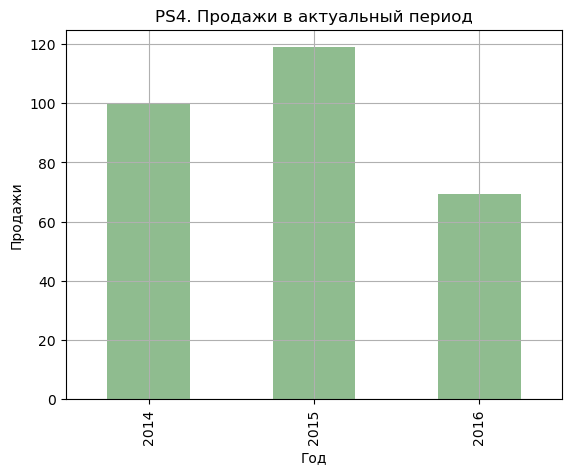

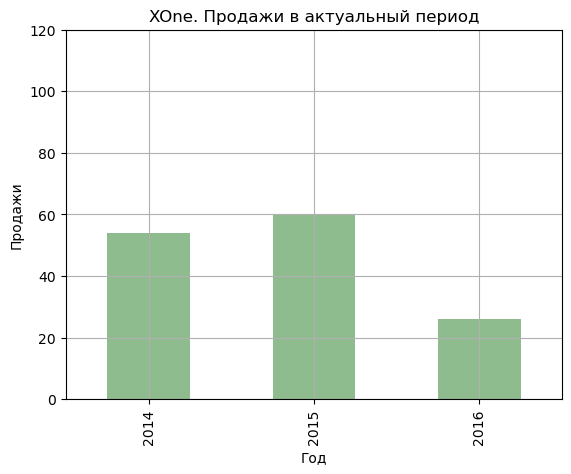

In [30]:
#ввела лимит по оси y чтобы отметить насколько продажи PS4 превышают продажи XOne


(data_top_pl.query('platform == "PS4"')
 .pivot_table(index='year_of_release', values='total_sales', aggfunc='sum')
 .plot(kind='bar', 
       color='#8FBC8F', 
       title= 'PS4. Продажи в актуальный период',
       xlabel='Год',
       ylabel='Продажи', legend=False, grid=True)
)

(data_top_pl.query('platform == "XOne"')
 .pivot_table(index='year_of_release', values='total_sales', aggfunc='sum')
 .plot(kind='bar', 
       color='#8FBC8F', 
       title= 'XOne. Продажи в актуальный период',
       xlabel='Год',
       ylabel='Продажи', legend=False, grid=True, ylim= (0, 120))
);

Как видно по графикам продажи видеоигр для платформ PS4 и XOne распределяются по годам в течении актуального периода схоже: до 2015 года наблюдается положительная тенденция к росту продаж количества копий видеоигр, пик продаж для обеих платформ приходится на 2015 год, в 2016 наблюдается спад (возможно этот спад объясним неполнотой данных для 2016 года, но мы будем считать что данные полные). Тем не менее опираясь на данные, полученные в исследовании ранее, жизненный цикл платформ еще не завершен, т.е. обе платформы еще будут популярны в 2017 и последующих годах, при этом их популярность будет угасать.


### Распределение продаж по платформам

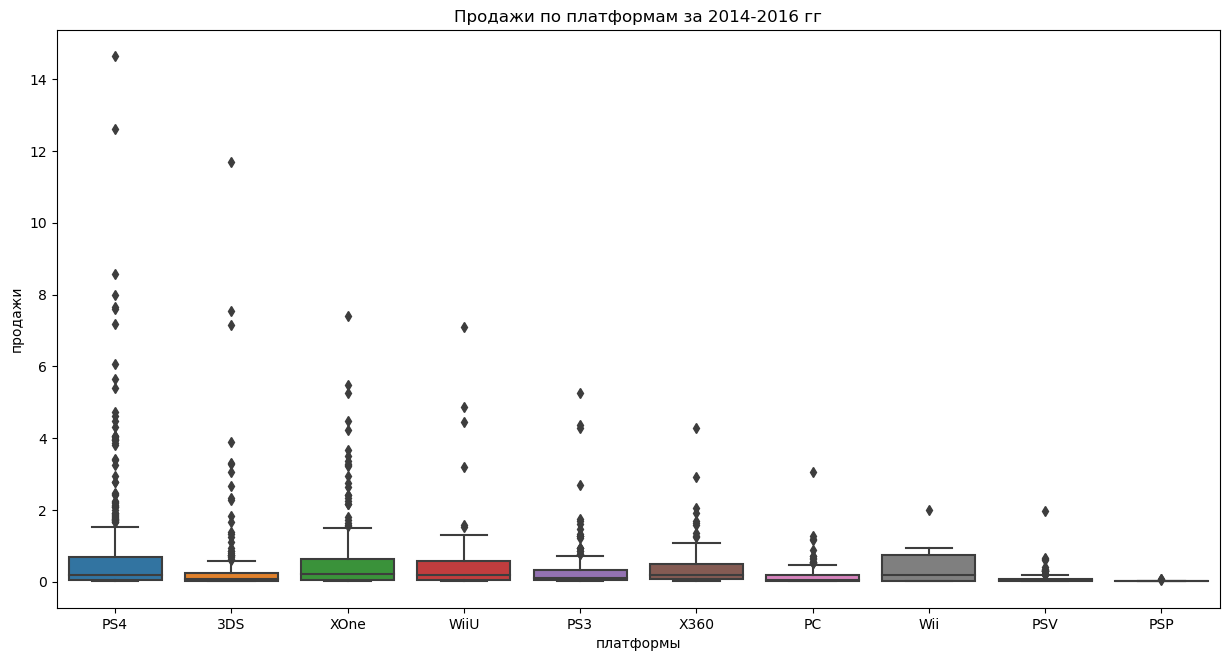

In [31]:
plt.figure(figsize=(15, 7.5))


sns.boxplot(data = data_actual, y = 'total_sales', x='platform')\
.set(title = 'Продажи по платформам за 2014-2016 гг', xlabel = 'платформы', ylabel = 'продажи');

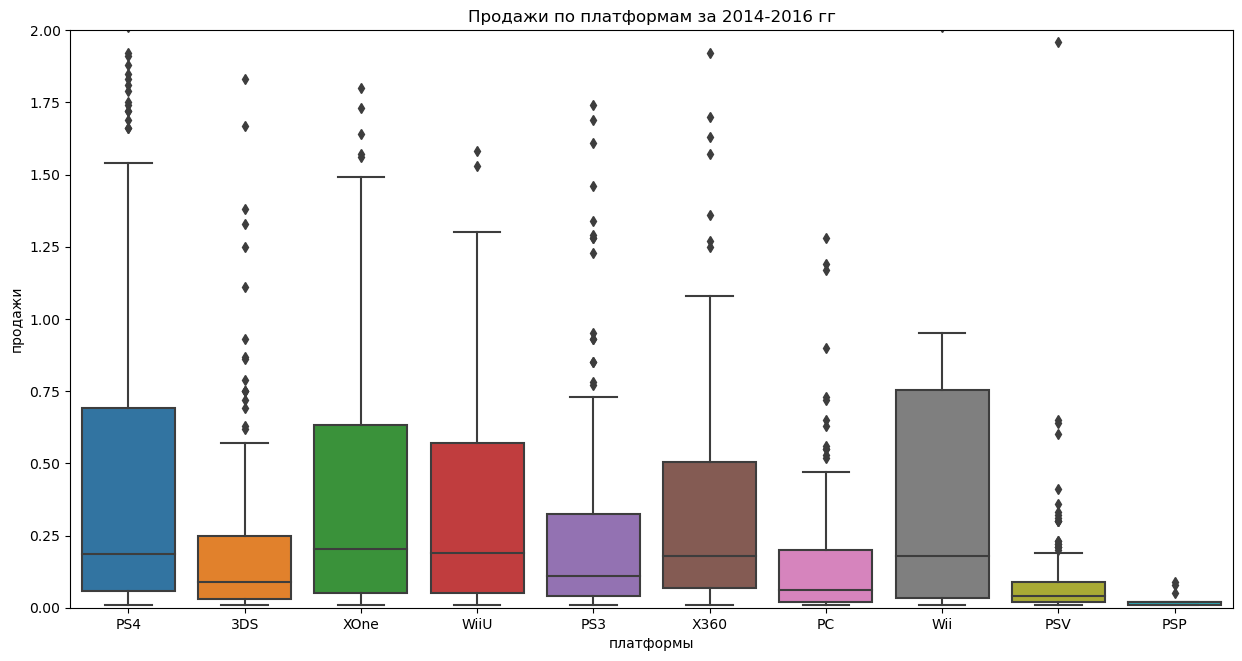

In [32]:
plt.figure(figsize=(15, 7.5))

#sns.set_palette( my_colors)

sns.boxplot(data = data_actual, y = 'total_sales', x='platform')\
.set(title = 'Продажи по платформам за 2014-2016 гг', 
    xlabel = 'платформы', ylabel = 'продажи', ylim=(0, 2));

Выбросы встречаются у платформ Wii, PSV, PSP. В целом все платформы имеют ожидаемое распределение.

In [33]:
data_actual.groupby('platform')['total_sales'].describe().sort_values(by='count', ascending=False)

,count,mean,std,min,25%,50%,75%,max
platform,,,,,,,,
PS4,376.0,0.766356,1.614969,0.01,0.0575,0.185,0.6900,14.63
PSV,295.0,0.075932,0.141591,0.01,0.0200,0.040,0.0900,1.96
XOne,228.0,0.615614,1.046513,0.01,0.0500,0.205,0.6325,7.39
PS3,219.0,0.311324,0.633059,0.01,0.0400,0.110,0.3250,5.27
3DS,212.0,0.408868,1.188368,0.01,0.0300,0.090,0.2500,11.68
PC,151.0,0.179139,0.329359,0.01,0.0200,0.060,0.2000,3.05
X360,111.0,0.434414,0.628967,0.01,0.0700,0.180,0.5050,4.28
WiiU,73.0,0.588767,1.161467,0.01,0.0500,0.190,0.5700,7.09
PSP,13.0,0.027692,0.027735,0.01,0.0100,0.020,0.0200,0.09


Рассмотрим подробнее потенциально прибыльные платформы PS4 и XOne:

Для PS4 cреднее значение (766 тыс продаж) более чем в 4 раза больше медианы (185 тыс продаж), это значит что в распределении есть несколько очень больших значений, которые влияют на среднее значение, возможно это связано с топ-играми т.е. играми с топовыми продажами (очень успешные).

Для XOne ситуация аналогичная cреднее значение (615 тыс продаж) более чем в 3 раза больше медианы (205 тыс продаж).

Еще стоит отметить платформу Wii у которой более 500 тыс проданных копий приходится всего на 73 игры, т.е. эти игры были очень успешны.      

### Влияние отзывов пользователей и критиков на продажи видеоигр

#### Влияние отзывов пользователей и критиков на продажи внутри платформы PS4

Определим влияют ли оценки пользователей и критиков на продажи внутри одной из потенциально прибыльных платформ PS4, для этого построим график совместного распределения показателей: оценок пользователей и продажами в первом случае и оценок критиков и продажами во втором случае.       

-0.040131589472697356

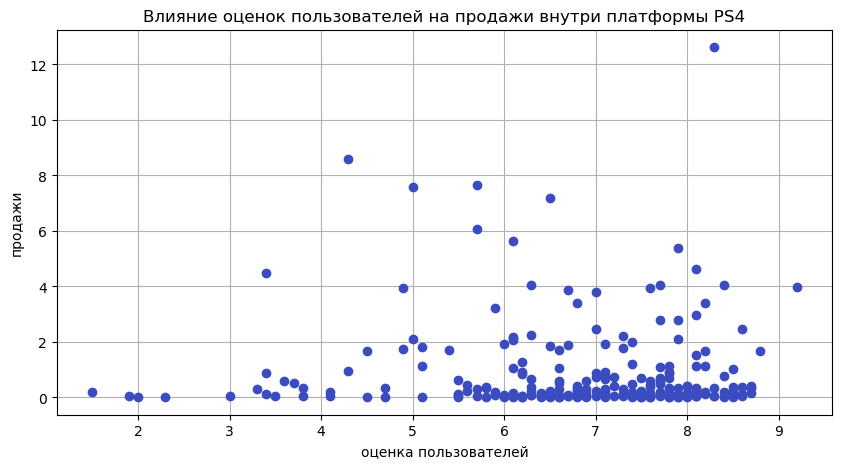

In [34]:
data_top_pl.query('platform == "PS4"').plot(
    x='user_score', 
    y='total_sales', 
    style='o', 
    grid=True, 
    figsize=(10, 5), 
    cmap='coolwarm', 
    title='Влияние оценок пользователей на продажи внутри платформы PS4', 
    xlabel='оценка пользователей', 
    ylabel='продажи', 
    legend=False)

data_top_pl.query('platform == "PS4"')['total_sales'].corr(data_top_pl.query('platform == "PS4"')['user_score'])

Как можно увидеть по графику зависимость продаж от оценок **пользователей** очень слабая (практически нет): корреляция слабо-отрицательная.   

0.40266141068104083

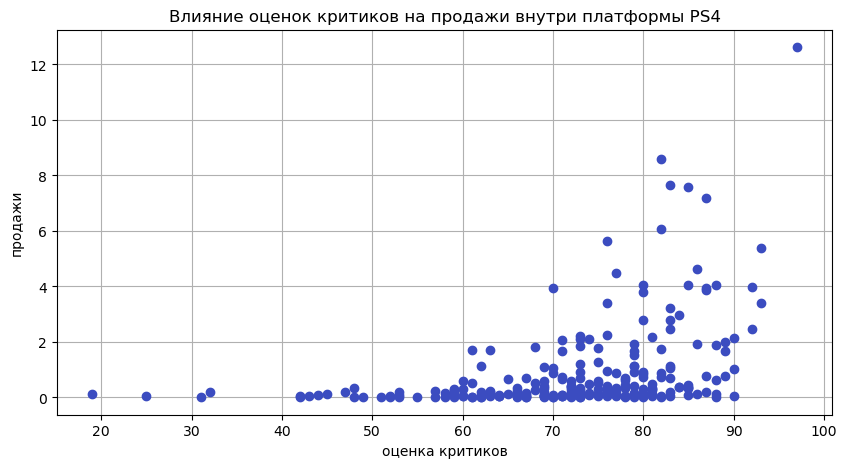

In [35]:
data_top_pl.query('platform == "PS4"').plot(
    x='critic_score', 
    y='total_sales', 
    style='o', 
    grid=True, 
    figsize=(10, 5), 
    cmap='coolwarm',   
    title='Влияние оценок критиков на продажи внутри платформы PS4', 
    xlabel='оценка критиков', 
    ylabel='продажи', 
    legend=False)

data_top_pl.query('platform == "PS4"')['total_sales'].corr(data_top_pl.query('platform == "PS4"')['critic_score'])

Как можно увидеть по графику зависимость продаж от оценок **критиков** слабая: корреляция слабо-положительная, т.е. с ростом оценки растет и число продаж. 

**Вывод:** продажи игр слабо зависят от оценок критиков и не зависят от оценок пользователей.       

#### Влияние отзывов пользователей и критиков на продажи игр внутри других платформ

Соотнесем выводы с продажами игр на других платформах. Для этого построим диаграммы рассеяния и определим коэффициенты корреляциии продаж и оценок пользователей для 5-ти платформ за актуальный период.

Влияние оценок пользователей на продажи внутри платформы 3DS


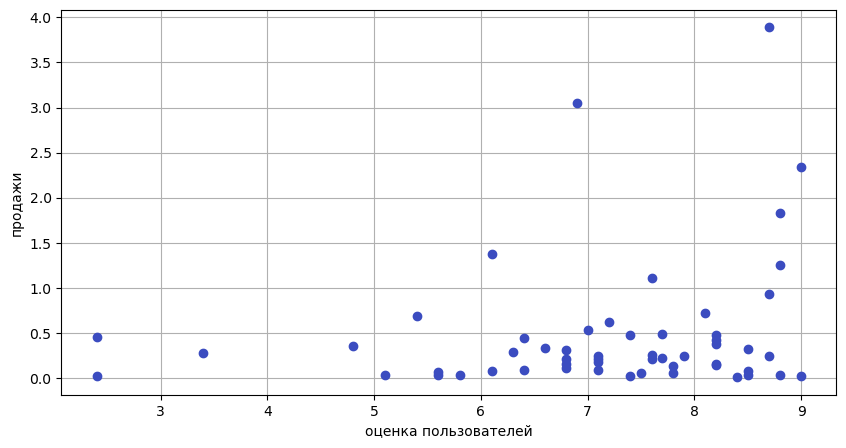

Коэффициент корреляции: 0.2151932718527028
____________________________________________________________________________________________________
Влияние оценок пользователей на продажи внутри платформы PS3


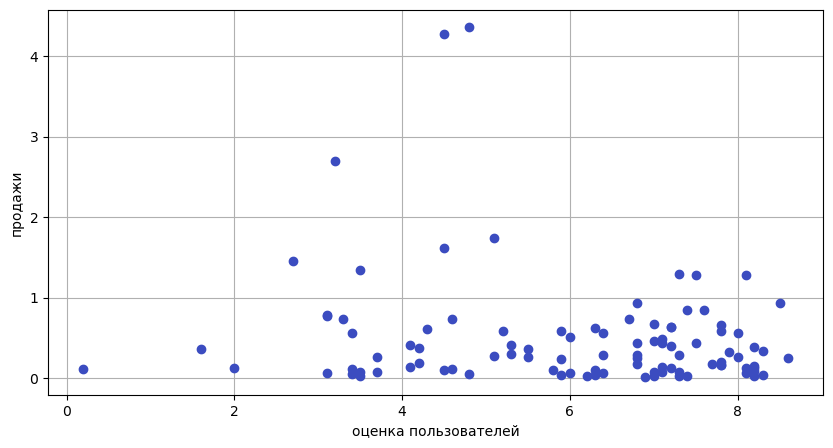

Коэффициент корреляции: -0.16676141347662116
____________________________________________________________________________________________________
Влияние оценок пользователей на продажи внутри платформы WiiU


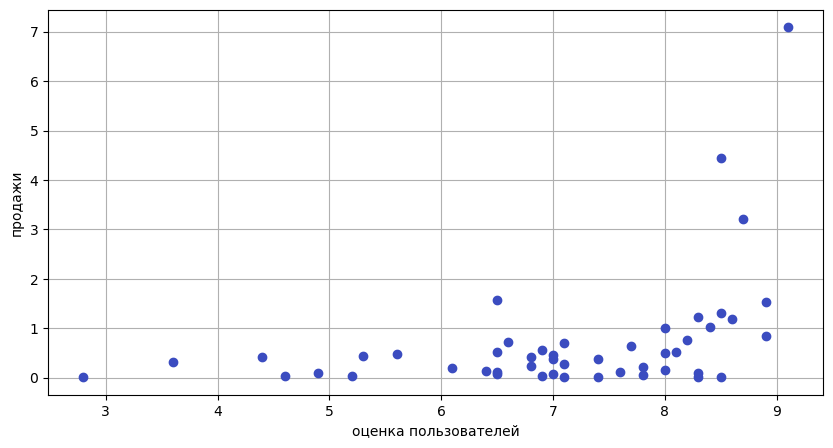

Коэффициент корреляции: 0.4079264579217078
____________________________________________________________________________________________________
Влияние оценок пользователей на продажи внутри платформы X360


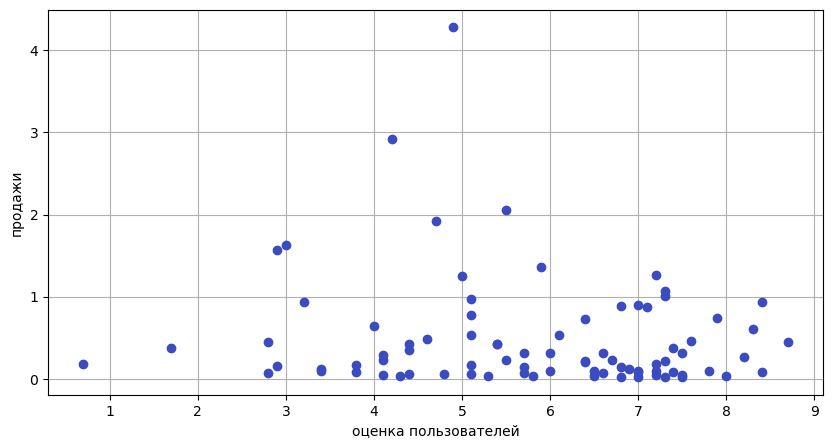

Коэффициент корреляции: -0.138444570945665
____________________________________________________________________________________________________
Влияние оценок пользователей на продажи внутри платформы XOne


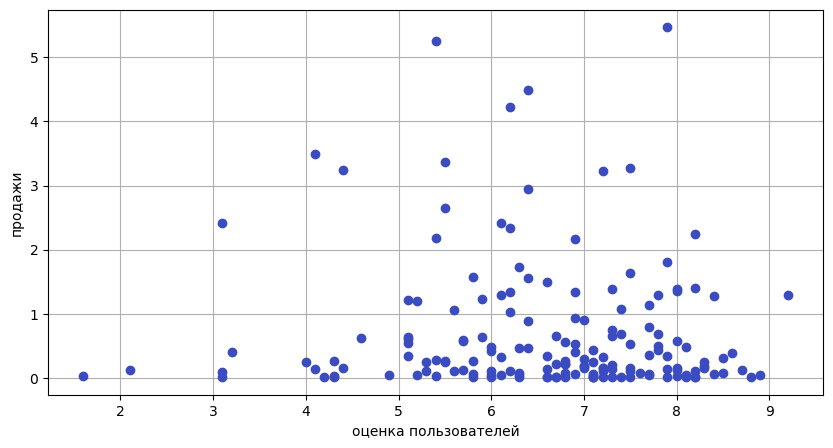

Коэффициент корреляции: -0.0703839280647581
____________________________________________________________________________________________________


In [36]:
pl = ['XOne', '3DS', 'PS3', 'X360', 'WiiU']

for platform, games_on_platform in data_actual.query('platform == @pl').groupby('platform'):
    print('Влияние оценок пользователей на продажи внутри платформы', platform)
    games_on_platform.plot(
        x='user_score', 
        y='total_sales', 
        style='o',
        grid=True, 
        figsize=(10, 5), 
        cmap='coolwarm',  
        xlabel='оценка пользователей', 
        ylabel='продажи', 
        legend=False)
    plt.show()
    print('Коэффициент корреляции:', games_on_platform['total_sales'].corr(games_on_platform['user_score']))
    print('_'*100)

Графическое представление взаимосвязи оценок **пользователей** и общими продажами видеоигр внутри конкретных платформ позволяет нам увидеть, что для некоторых платформ, например 3DS, WiiU, характерна положительная корреляция, это значит что с ростом оценки пользователей количество продаж видеоигр увеличивается. А для некоторых платформ: PS3, X360, XOne наоборот, корреляция отрицательная, т.е. отмечаются высокие продажи видеоигр при невысокой оценке пользователей.
    
Из чего можно сделать вывод что оценка пользователей имеет слабое влияние на общие продажи видеоигр в целом, возможно конкретные игры (к примеру очень ожидаемые среди пользователей) провоцируют большое количество продаж, при этом получают низкие оценки, что приводит к разной взаимосвязи оценок пользователей и продажи в разбивке на платформы.

Также построим диаграммы рассеяния и определим коэффициенты корреляциии продаж и оценок критиков для 5-ти платформ за актуальный период.


Влияние оценок критиков на продажи внутри платформы 3DS


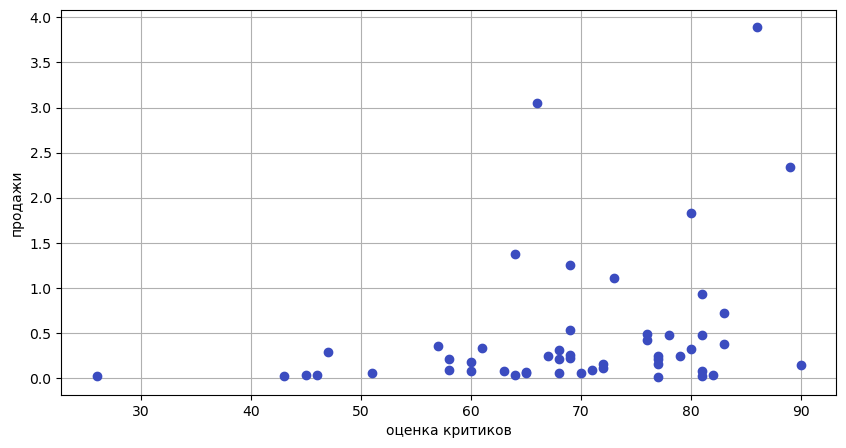

Коэффициент корреляции: 0.31411749286905105
____________________________________________________________________________________________________
Влияние оценок критиков на продажи внутри платформы PS3


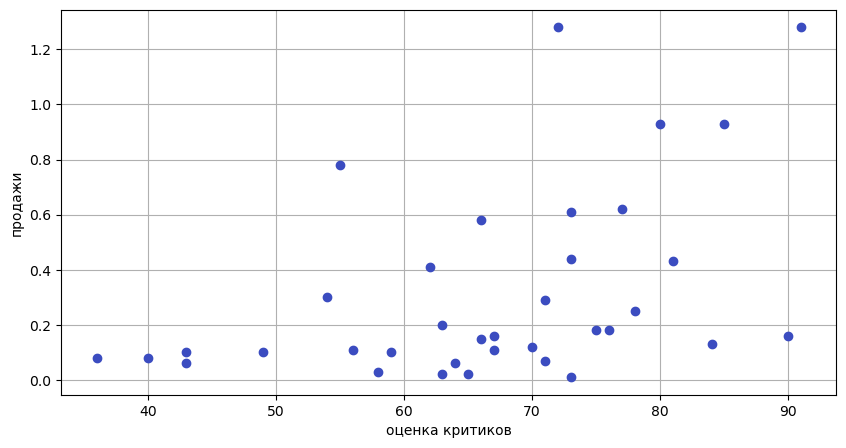

Коэффициент корреляции: 0.44657460493190704
____________________________________________________________________________________________________
Влияние оценок критиков на продажи внутри платформы WiiU


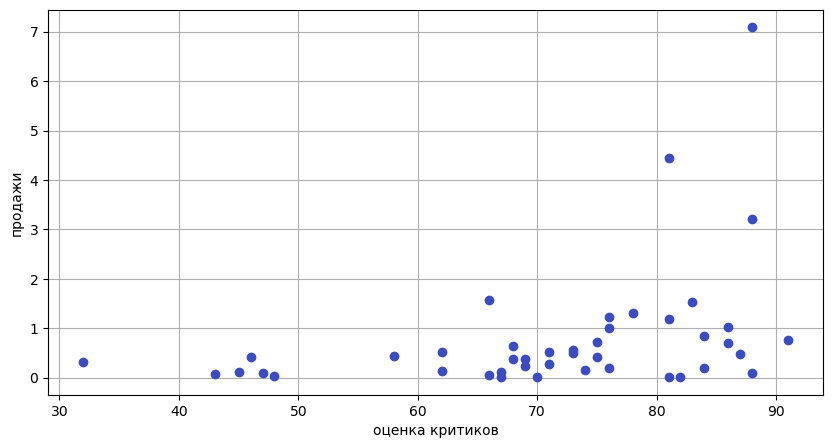

Коэффициент корреляции: 0.370201412480884
____________________________________________________________________________________________________
Влияние оценок критиков на продажи внутри платформы X360


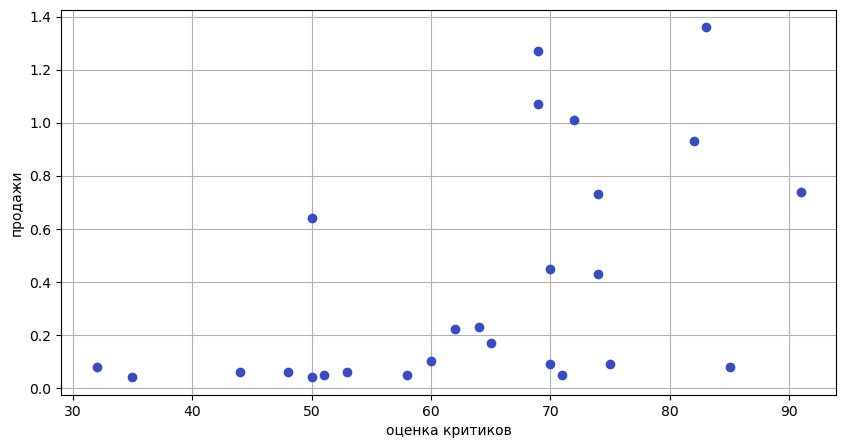

Коэффициент корреляции: 0.5257228356581523
____________________________________________________________________________________________________
Влияние оценок критиков на продажи внутри платформы XOne


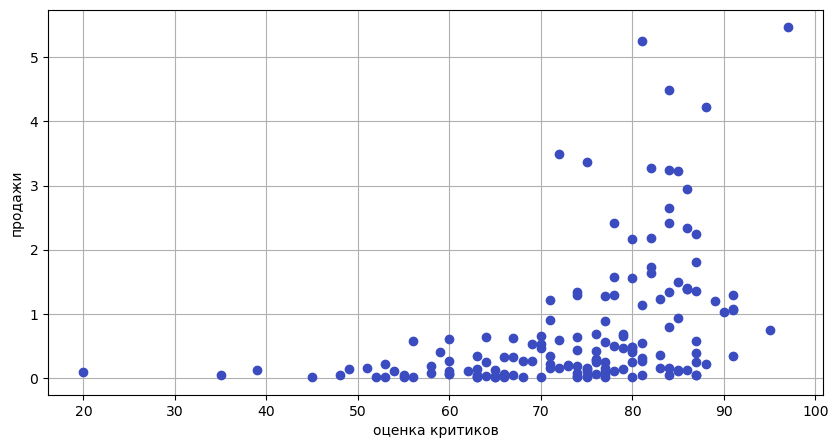

Коэффициент корреляции: 0.42867694370333226
____________________________________________________________________________________________________


In [37]:

for platform, games_on_platform in data_actual.query('platform == @pl').groupby('platform'):
    print('Влияние оценок критиков на продажи внутри платформы', platform)
    games_on_platform.plot(
        x='critic_score', 
        y='total_sales', 
        style='o',
        grid=True, 
        figsize=(10, 5), 
        cmap='coolwarm',  
        xlabel='оценка критиков', 
        ylabel='продажи', 
        legend=False)
    plt.show()
    print('Коэффициент корреляции:', games_on_platform['total_sales'].corr(games_on_platform['critic_score']))
    print('_'*100)
    

В случае с оценками **критиков**, наоборот, можно выделить общую тенденцию их влияния на продажи видеоигр внутри рассматриваемых нами платформ. Корреляция во всех случаях слабая положительная, это значит что чем выше оценка критиков тем выше продажи видеоигр. Исходя из этих данных можно сделать вывод что оценка критиков имеет большее влияние на продажи видеоигр чем оценка пользователей.

### Распределение игр по жанрам

Построим круговую диаграмму распределения игр по жанрам и посмотрим какие жанры преобладают по количеству выпускаемых игр за актуальный период.

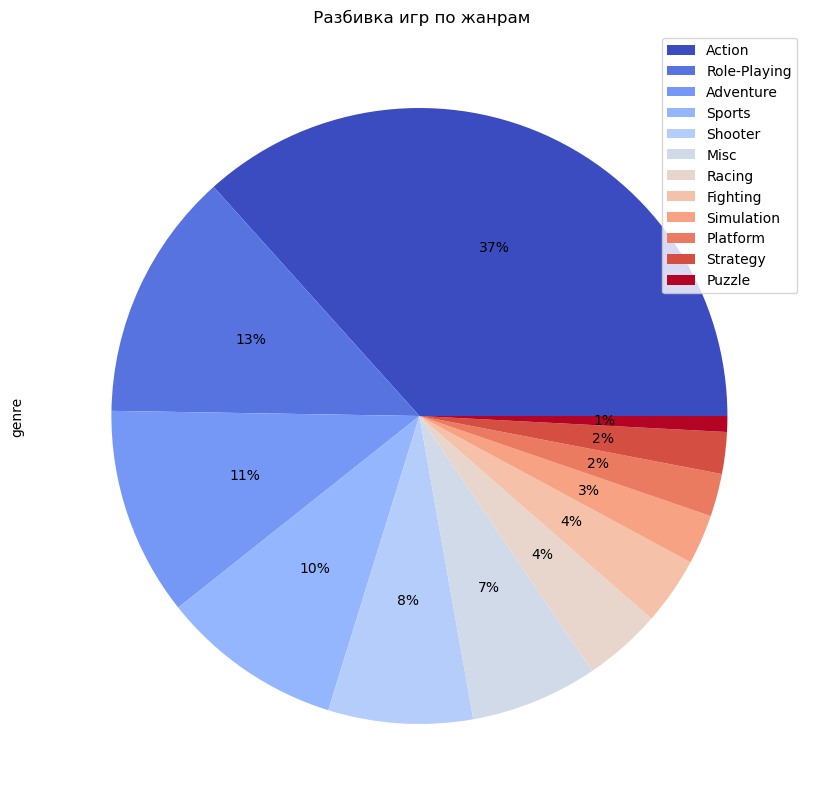

In [38]:
(data_actual.groupby('genre')['genre'].agg('count').sort_values(ascending=False)
 .plot(grid=True, figsize=(10, 10), kind='pie', cmap='coolwarm', 
      title= ' Разбивка игр по жанрам', legend=True, labels=None, autopct='%1.0f%%'))

plt.show()

Как видно по круговой диаграмме количественно преобладают жанры: Action (37% от всех видеоигр выборки), Role-Playing (13%), Adventure (11%), Sports (10%), Shooter (8%). Посмотрим как распределяются продажи копий видеоигр по жанрам.

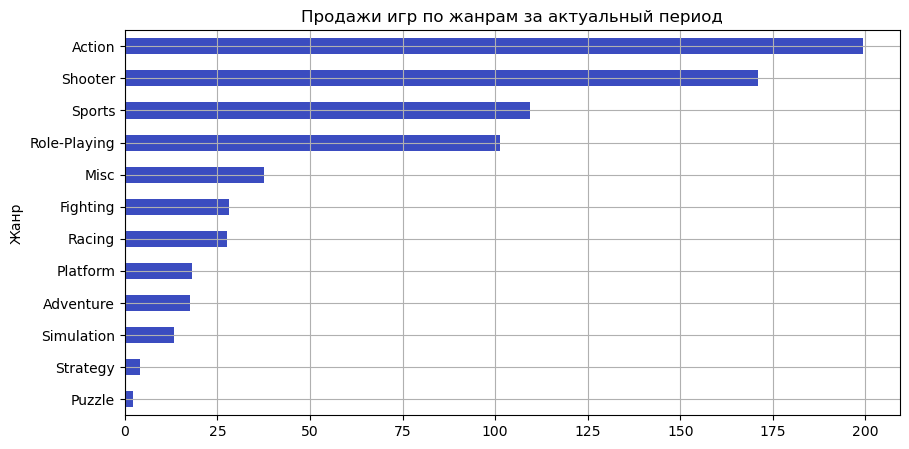

In [39]:
(data_actual.pivot_table(
    index='genre', 
    values='total_sales',
    aggfunc='sum').sort_values(
    by='total_sales', ascending=True)
 .plot(grid=True, figsize=(10, 5), kind='barh', cmap='coolwarm', 
      title= 'Продажи игр по жанрам за актуальный период',
      xlabel='Жанр',
      ylabel='Продажи',
      legend=False) 
)
plt.show()

Наиболее продаваемыми являются жанры: Action, Shooter, Sports, Role-Playing (более 50 млн проданных копий)

Жанры Action также преобладает и количественно. Жанр Shooter занимает пятое место по количеству выпущенных игр, при этом второе место по продажам. Также стоит отметить жанр Adventure который занимает второе место по количеству выпущенных игр при этом не входит в топ-5 самых продаваемых жанров.      

Рассмотрим какие жанры самые продаваемые в рамках потенциально прибыльных платформ (PS4, XOne)

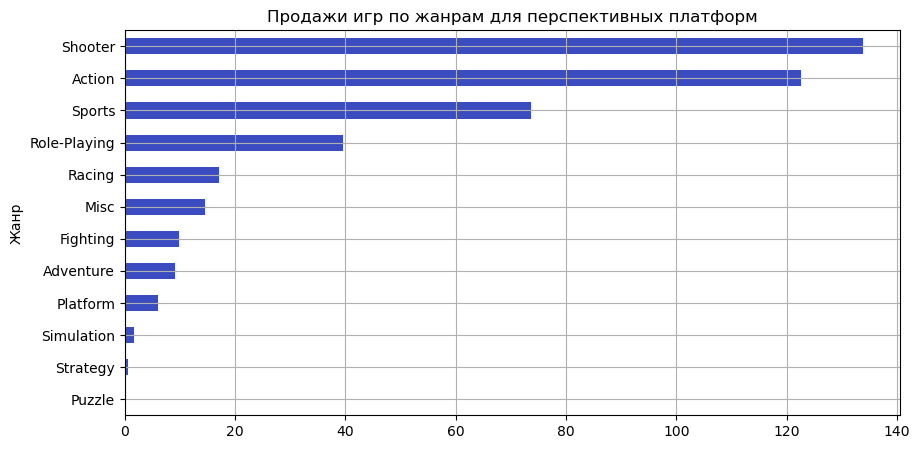

In [40]:
(data_top_pl.pivot_table(
    index='genre', 
    values='total_sales',
    aggfunc='sum').sort_values(
    by='total_sales', ascending=True)
 .plot(grid=True, figsize=(10, 5), kind='barh', cmap='coolwarm', 
      title= 'Продажи игр по жанрам для перспективных платформ',
      xlabel='Жанр',
      ylabel='Продажи',
      legend=False) 
)
plt.show()

Наиболее продаваемыми в рамках потенциально прибыльных платформ являются жанры: Shooter, Action,  Sports, Role-Playing, Racing. При этом возглавляет топ-5 жанр Shooter, который являлся вторым по продажам в рамках всех платформ за актуальный период.     

Также сравним медианные продажи видеоигр по жанрам, чтобы определить наиболее стабильные жанры - жанры на которые существует устойчивый спрос независимо от успешности платформы:  

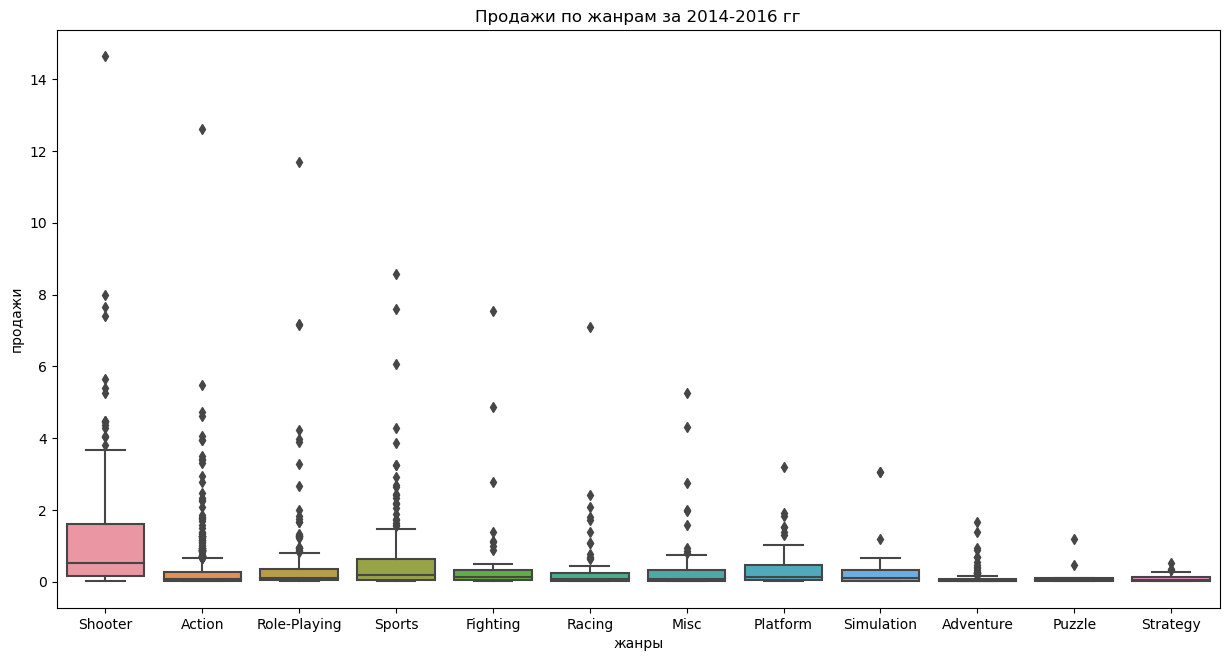

In [41]:
plt.figure(figsize=(15, 7.5))


sns.boxplot(data = data_actual, y = 'total_sales', x='genre')\
.set(title = 'Продажи по жанрам за 2014-2016 гг', xlabel = 'жанры', ylabel = 'продажи');

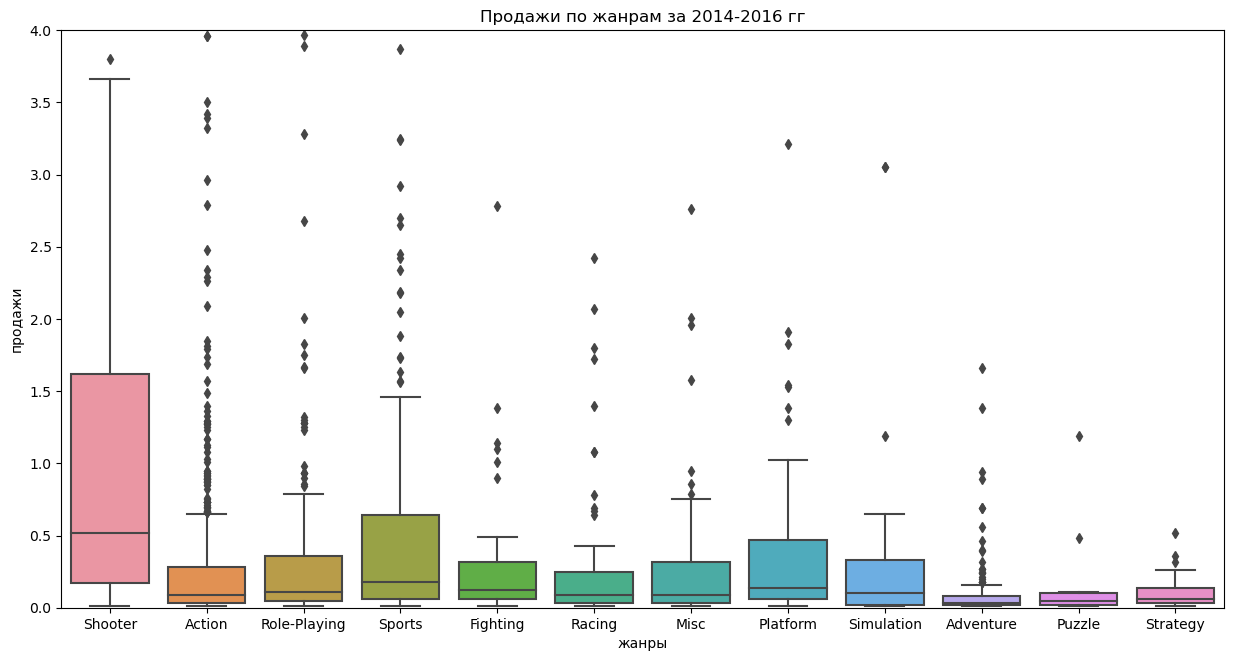

In [42]:
plt.figure(figsize=(15, 7.5))

#sns.set_palette( my_colors)

sns.boxplot(data = data_actual, y = 'total_sales', x='genre')\
.set(title = 'Продажи по жанрам за 2014-2016 гг', 
    xlabel = 'жанры', ylabel = 'продажи', ylim=(0, 4));

In [43]:
data_actual.groupby('genre')['total_sales'].describe().sort_values(by='count', ascending=False)

,count,mean,std,min,25%,50%,75%,max
genre,,,,,,,,
Action,619.0,0.322068,0.798181,0.01,0.0300,0.090,0.2800,12.62
Role-Playing,221.0,0.459005,1.177284,0.01,0.0500,0.110,0.3600,11.68
Adventure,185.0,0.094865,0.203147,0.01,0.0200,0.030,0.0800,1.66
Sports,161.0,0.680000,1.239736,0.01,0.0600,0.180,0.6400,8.58
Shooter,128.0,1.335469,2.050567,0.01,0.1725,0.515,1.6175,14.63
Misc,113.0,0.332301,0.736999,0.01,0.0300,0.090,0.3200,5.27
Racing,69.0,0.398841,0.963716,0.01,0.0300,0.090,0.2500,7.09
Fighting,60.0,0.470333,1.188053,0.01,0.0600,0.125,0.3200,7.55
Simulation,44.0,0.298409,0.646925,0.01,0.0200,0.100,0.3275,3.05


С помощью диаграмм размаха можно сделать следующие выводы: жанр Shooter единственный жанр чье медианное значение продаж превышает 500 тыс. копий видеоигр, таже к жанрам с устойчивым спросом можно отнести: Sports, Platform, Role-Playng, Fighting и Action.

## Портрет пользователя каждого региона<a id='intro4'></a>

Определим портрет пользователя для каждого региона: для этого определим его жанровые предпочтения, предпочитаемую платформу и возрастную группу.

### Топ-5 самых популярных жанров в отдельных регионах

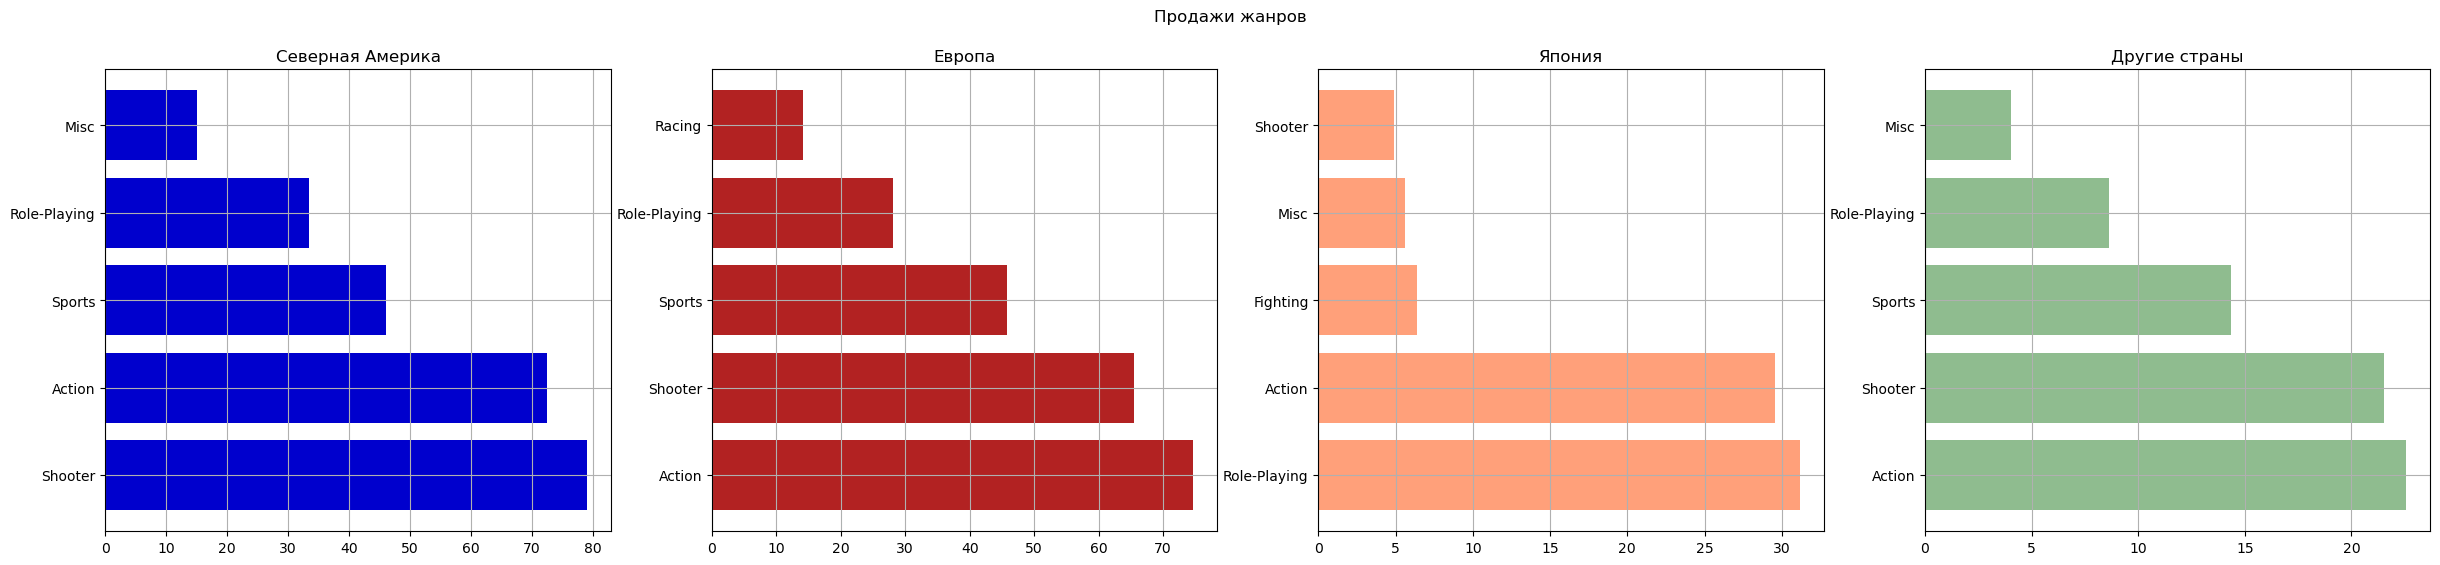

In [44]:
na_genre = data_actual.pivot_table(index='genre', values='na_sales', aggfunc='sum').sort_values(
    by='na_sales', ascending=False).head()
eu_genre = data_actual.pivot_table(index='genre', values='eu_sales', aggfunc='sum').sort_values(
    by='eu_sales', ascending=False).head()
jp_genre = data_actual.pivot_table(index='genre', values='jp_sales', aggfunc='sum').sort_values(
    by='jp_sales', ascending=False).head()
other_genre = data_actual.pivot_table(index='genre', values='other_sales', aggfunc='sum').sort_values(
    by='other_sales', ascending=False).head()

fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(30, 6))
fig.suptitle('Продажи жанров')

ax1.barh(na_genre.index, na_genre['na_sales'], color='#0000CD')
ax1.set_title('Северная Америка')
ax1.grid(True)

ax2.barh(eu_genre.index, eu_genre['eu_sales'], color='#B22222')
ax2.set_title('Европа')
ax2.grid(True)

ax3.barh(jp_genre.index, jp_genre['jp_sales'], color='#FFA07A')
ax3.set_title('Япония')
ax3.grid(True)

ax4.barh(other_genre.index, other_genre['other_sales'], color='#8FBC8F')
ax4.set_title('Другие страны')
ax4.grid(True)


**Вывод:** Графики показывают, что пользователи Северной Америки предпочитают жанр Shooter, пользователям Европы и Других стран (отличных от Северной Америки, Европы и Японии) предпочтительнее жанр Action, а большинство пользователей из Японии отдают предпочтение жанру Role-Playing.

При этом стоить отметить что на лидирующих позициях в Северной Америке, Европе и Других странах два одинаковых жанра Shooter и Action, в то время как в Японии первенство делят Role-Playing и Action (а жанр Shooter замыкает топ-5).    

</div>

### Топ-5 самых популярных платформ в отдельных регионах

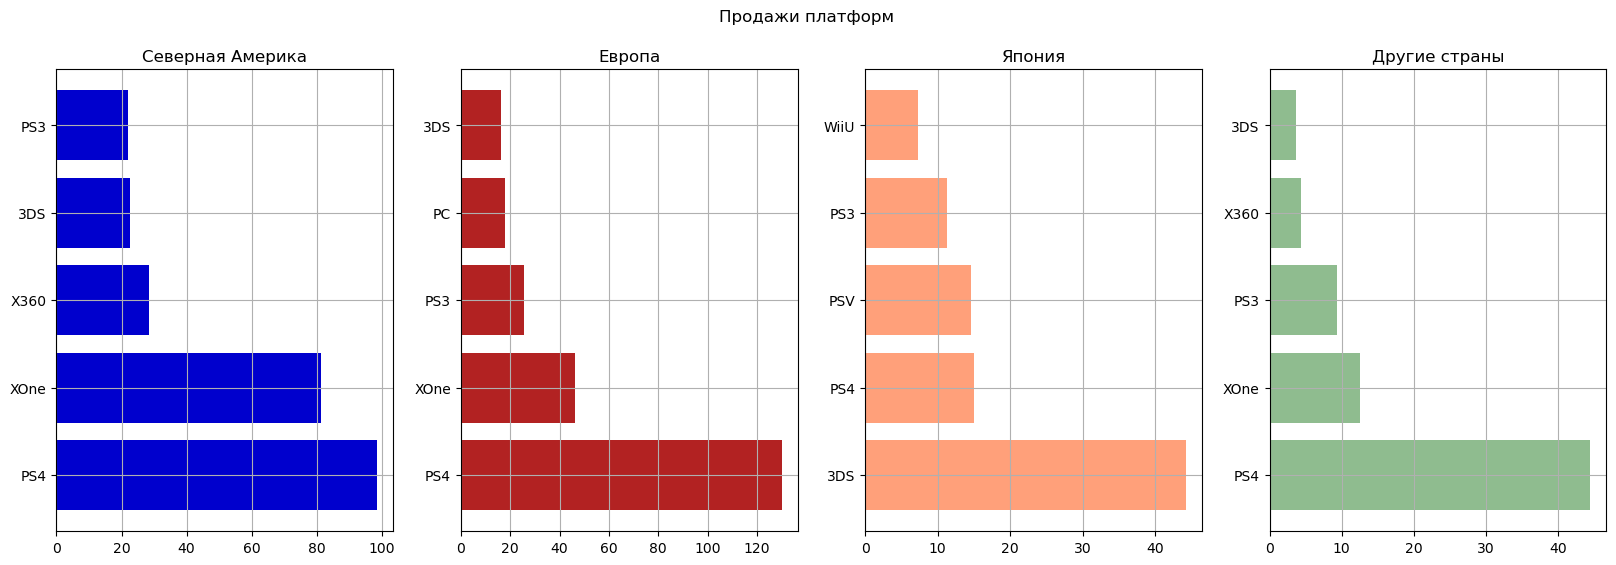

In [45]:
na_sales = data_actual.pivot_table(index='platform', values='na_sales', aggfunc='sum').sort_values(
    by='na_sales', ascending=False).head()
eu_sales = data_actual.pivot_table(index='platform', values='eu_sales', aggfunc='sum').sort_values(
    by='eu_sales', ascending=False).head()
jp_sales = data_actual.pivot_table(index='platform', values='jp_sales', aggfunc='sum').sort_values(
    by='jp_sales', ascending=False).head()
other_sales = data_actual.pivot_table(index='platform', values='other_sales', aggfunc='sum').sort_values(
    by='other_sales', ascending=False).head()

fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(20, 6))
fig.suptitle('Продажи платформ')

ax1.barh(na_sales.index, na_sales['na_sales'], color='#0000CD')
ax1.set_title('Северная Америка')
ax1.grid(True)

ax2.barh(eu_sales.index, eu_sales['eu_sales'], color='#B22222')
ax2.set_title('Европа')
ax2.grid(True)

ax3.barh(jp_sales.index, jp_sales['jp_sales'], color='#FFA07A')
ax3.set_title('Япония')
ax3.grid(True)

ax4.barh(other_sales.index, other_sales['other_sales'], color='#8FBC8F')
ax4.set_title('Другие страны')
ax4.grid(True)



**Вывод:** Предпочтения по платформам для видеоигр распределяются одинаковым образом для 3 из 4 различных регионов: пользователи Северной Америки, Европы и Других стран предпочитают платформу PS4, а на втором месте топ-5 этих регионов расположилась платформа XOne. Отличная ситуация для пользователей из Японии: они отдают свои предпочтения платформе 3DS, платформа PS4 расположилась в их регионе на 2 месте уступая 3DS более чем в 2,5 раза.      

### Влияние рейтинга ESRB на продажи в отдельных регионах

Построим круговую диаграмму распределения игр по возрастным рейтингам и посмотрим какие рейтинги преобладают по количеству выпускаемых игр за актуальный период.

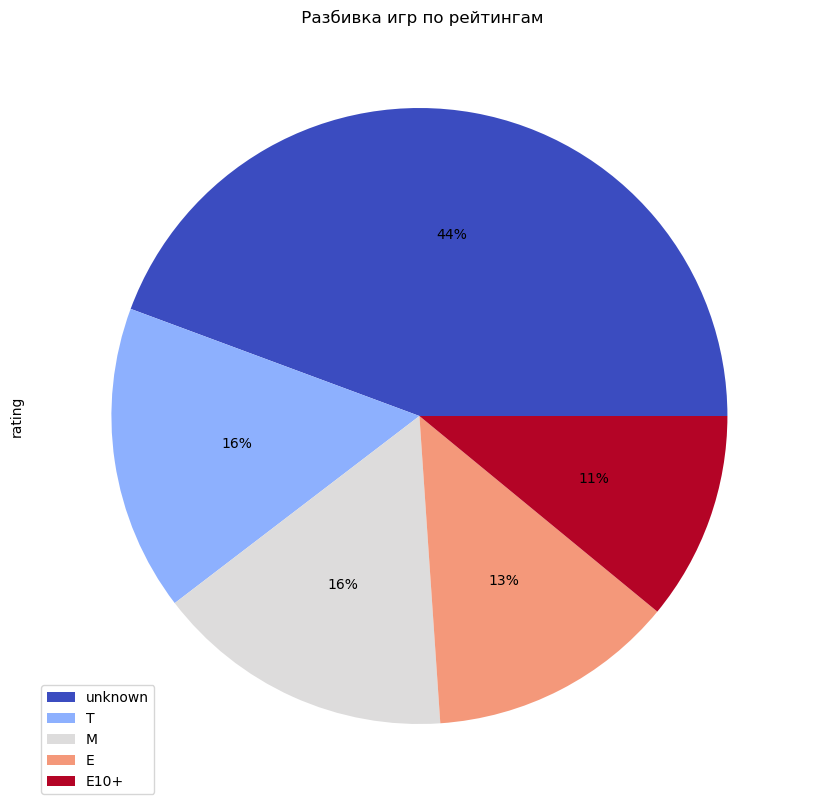

In [46]:
(data_actual.groupby('rating')['rating'].agg('count').sort_values(ascending=False)
 .plot(grid=True, figsize=(10, 10), kind='pie', cmap='coolwarm', 
      title= ' Разбивка игр по рейтингам', legend=True, autopct='%1.0f%%', labels=None))

plt.show()

БОльшая доля рейтингов нам не известна: 44% игр с неопределенным значением по этому показателю, 16% с рейтингом «T» — «Подросткам», 16% с рейтингом «M» — «Для взрослых», 13% «E» — «Для всех», 11% «E10+» — «Для всех от 10 лет и старше».

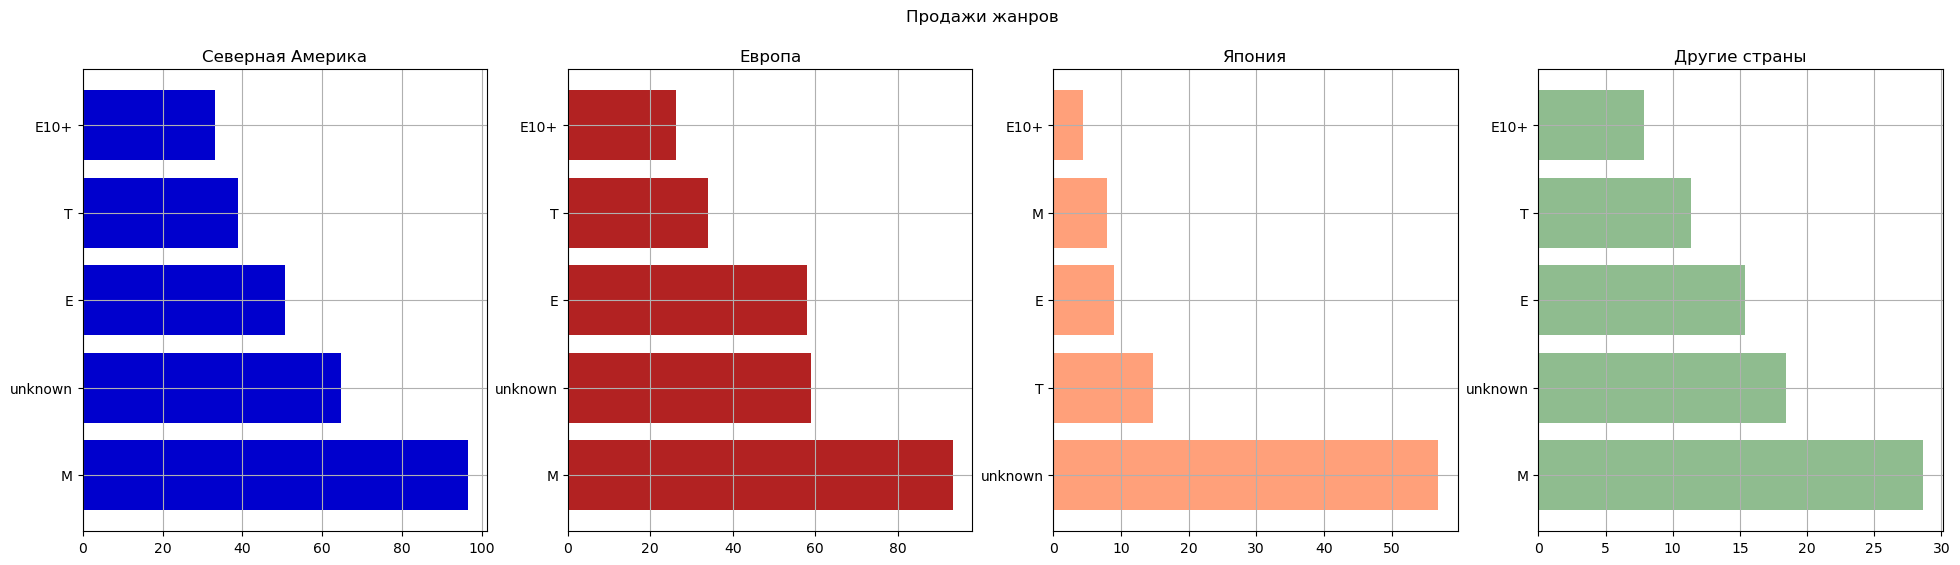

In [47]:
na_rating = data_actual.pivot_table(index='rating', values='na_sales', aggfunc='sum').sort_values(
    by='na_sales', ascending=False)
eu_rating = data_actual.pivot_table(index='rating', values='eu_sales', aggfunc='sum').sort_values(
    by='eu_sales', ascending=False)
jp_rating = data_actual.pivot_table(index='rating', values='jp_sales', aggfunc='sum').sort_values(
    by='jp_sales', ascending=False)
other_rating = data_actual.pivot_table(index='rating', values='other_sales', aggfunc='sum').sort_values(
    by='other_sales', ascending=False)

fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(24, 6))
fig.suptitle('Продажи жанров')

ax1.barh(na_rating.index, na_rating['na_sales'], color='#0000CD')
ax1.set_title('Северная Америка')
ax1.grid(True)

ax2.barh(eu_rating.index, eu_rating['eu_sales'], color='#B22222')
ax2.set_title('Европа')
ax2.grid(True)

ax3.barh(jp_rating.index, jp_rating['jp_sales'], color='#FFA07A')
ax3.set_title('Япония')
ax3.grid(True)

ax4.barh(other_rating.index, other_rating['other_sales'], color='#8FBC8F')
ax4.set_title('Другие страны')
ax4.grid(True)

**Вывод:** Рейтинг «M» — «Для взрослых» характерен для пользователей 3 регионов: Северная Америка, Европа и Другие страны, из чего можно сделать вывод что типичный пользователь из этого региона человек старше 18 лет (взрослый). Отличная ситуация в Японии: согласно распределению в этом регионе преобладает неопределенный рейтинг, это связано с тем, что ESRB (Entertainment Software Rating Board) - ассоциация, определяющей возрастной рейтинг компьютерных видеоигр в **США и Канаде**, скорее всего для индустрии видеоигр Японии возрастной рейтинг данной организации неважен.
    
</div>

Исходя из исследований показателей разных регионов можно сделать следующие **выводы:**

1. Портрет пользователя Северной Америки:
* жанровые предпочтения: Shooter, Action 
* предпочитаемая платформа: PS4, XOne
* возрастная группа: взрослые

2. Портрет пользователя Европы:
* жанровые предпочтения: Action, Shooter
* предпочитаемая платформа: PS4, XOne
* возрастная группа: взрослые

3. Портрет пользователя Японии:
* жанровые предпочтения: Role-Playing, Action
* предпочитаемая платформа: 3DS, PS4
* возрастная группа: невозможно определить по имеющимся данным

4. Портрет пользователя Других стран:
* жанровые предпочтения: Action, Shooter
* предпочитаемая платформа: PS4, XOne
* возрастная группа: взрослые

Типичные портреты пользователей Северной Америки, Европы и Других стран (отличных от Японии) идентичны, предпочтения у пользователей этих регионов совпадают по всем 3 пунктам: жанр, платформа, возраст.

Типичный пользователь из Японии существенно отличается от остальных трех рассматриваемых регионов и по предпочитаемым жанрам и по предпочитаемым платформам.       


## Статистический анализ данных. Проверка гипотез 

Проведем статистический анализ данных: проверим приведенные ниже гипотезы. Для их проверки необходимо сформулировать нулевую и альтернативную (принимается в случае опровержения нулевой) гипотезы, сделаем это исходя из равенства, т.е. нулевая гипотеза должна передавать информацию о том что одна метрика равна другой метрике, в качестве альтернативной примем обратную гипотезу, т.е. гипотезу о том что эти метрики не равны.
    
В нашем случае мы будем проверять гипотезы:
1. Средние пользовательские рейтинги платформ Xbox One и PC одинаковые
2. Средние пользовательские рейтинги жанров Action и Sports разные

Иными словами мы будем проверять гипотезы о равенстве средних двух генеральных совокупностей: исследовать пользовательские рейтинги различных платформ и жанров и на основании взятых из них случайных выборок делать вывод о том, считать ли эти рейтинги одинаковыми или нет.

Инструментом для проверки этих двух гипотез станет t-тест, мы можем его использовать т.к. исследуемые генеральные совокупности не зависят друг от друга, данных достаточно чтобы считать что средние выборок нормально распределены, однако существуют сомнения, что выборки имеют одинаковый размер и дисперсии у совокупностей одинаковые, поэтому укажем параметр equal_var как False (благодаря этому тест посчитает дисперсии выборок по отдельности)

### Средние пользовательские рейтинги платформ Xbox One и PC одинаковые 
```
H_0: Оценка пользователей (user_score) игр на платформе Xbox One  = оценке пользователей (user_score) видеоигр на платформе PC
H_a: Оценка пользователей (user_score) игр на платформе Xbox One  ≠ оценке пользователей (user_score) видеоигр на платформе PC
alpha = 0.05
```

Проверим гипотезу в рамках актуального периода (т.е. для данных лет и платформ актуального периода (2014-2016 гг)   

In [48]:
from scipy import stats as st

In [49]:
data_actual = data_actual.dropna(subset=['user_score']).reset_index(drop=True)

In [50]:
user_score_xone = data_actual.query('platform == "XOne"')['user_score']
user_score_pc = data_actual.query('platform == "PC"')['user_score']

results= st.ttest_ind(user_score_xone, user_score_pc, equal_var=False)
alpha = .05

print(results.pvalue)

if results.pvalue < alpha:
    print('Отвергаем нулевую теорию')
else:
    print('Не получилось отвергнуть нулевую теорию')

0.11601398086668832
Не получилось отвергнуть нулевую теорию


**Вывод:** на имеющихся данных, на уровне значимости 5% есть основания отвергнуть нулевую гипотезу о равенстве средних значений пользовательских рейтингов (отзывов) платформ Xbox One и PC в пользу альтернативной гипотезы.

### Средние пользовательские рейтинги жанров Action и Sports разные
```
H_0: Оценка пользователей (user_score) игр жанра Action = оценке пользователей (user_score) видеоигр жанра Sports
H_a: Оценка пользователей (user_score) игр жанра Action ≠ оценке пользователей (user_score) видеоигр жанра Sports
alpha = 0.05
```

Проверим гипотезу в рамках актуального периода (т.е. для данных лет и платформ актуального периода (2014-2016 гг)   

In [51]:
user_score_action = data_actual.query('genre == "Action"')['user_score']
user_score_sports = data_actual.query('genre == "Sports"')['user_score']

results= st.ttest_ind(user_score_action, user_score_sports, equal_var=False)
alpha = .05

print(results.pvalue)

if results.pvalue < alpha:
    print('Отвергаем нулевую теорию')
else:
    print('Не получилось отвергнуть нулевую теорию')

1.1825550382644557e-14
Отвергаем нулевую теорию


**Вывод:** на имеющихся данных, на уровне значимости 5% есть основания отвергнуть нулевую гипотезу о равенстве средних значений пользовательских рейтингов (отзывов) жанров Action и Sports в пользу альтернативной гипотезы.

Проиллюстрируем наши выводы:

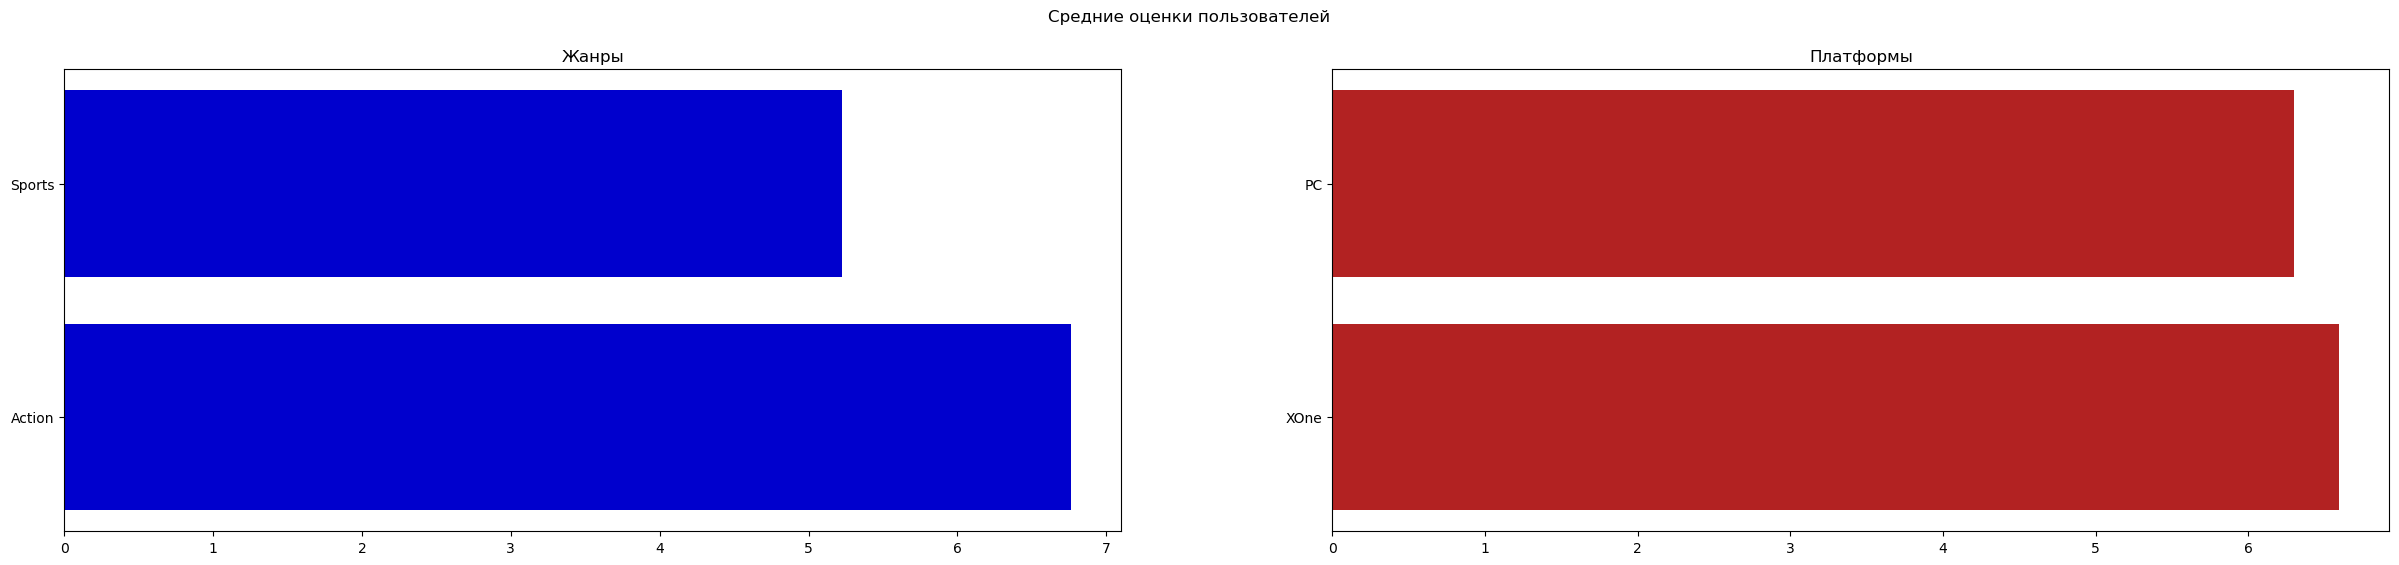

In [52]:
user_score_genre = data_actual.query('genre == "Action" | genre == "Sports"').pivot_table(
    index='genre', values='user_score', aggfunc='mean').sort_values(
    by='user_score', ascending=False)
user_score_platform = data_actual.query('platform == "XOne" | platform == "PC"').pivot_table(
    index='platform', values='user_score', aggfunc='mean').sort_values(
    by='user_score', ascending=False)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(30, 6))
fig.suptitle('Средние оценки пользователей')

ax1.barh(user_score_genre.index, user_score_genre['user_score'], color='#0000CD')
ax1.set_title('Жанры')


ax2.barh(user_score_platform.index, user_score_platform['user_score'], color='#B22222')
ax2.set_title('Платформы');

In [53]:
display(user_score_genre, user_score_platform)

,user_score
genre,
Action,6.760606
Sports,5.225197


,user_score
platform,
XOne,6.594545
PC,6.298361


## Результаты исследования

Резюмируя проделанную работу:
    
   1. При **первичном знакомстве с данными** и оценке их качества было выявлено большое количество пропущенных значений в данных(доли пропусков по некоторым столбцам составляли более 40%). Пропущенные значения были обработы следующим образом:
   * строки с пропущенными значениями в столбцах `name`, `genre`, `year_of_release` были удалены т.к. доля пропущенных значений по ним составляла менее 2%
   * аббревиатура "tbd" в стобце `user_score` была принята пустой и заменена на NaN (предположить, что такой ответ выбирают пользователи, которые еще не приняли решение как оценить игру)
   * пропущенные значения в столбце`rating` были заменены значениями "unknown"
   * пропущенные значения в столбцах `critic_score`, `user_score` были оставлены пропущенными

   2. В ходе первой части **исследовательского анализа данных** были рассмотренны:
   * количество игр выпускаемое в год
   * продажи игр для разных платформ
    
   Что позволило нам найти распределение продаж игр для конкретных платформ по годам и определить жизненные циклы платформ. Результатом первой части исследовательского анализа стал обусловленный **актуальный период (2014-2016 г)**, используемый в дальнейшем исследование.
   Во второй части исследовательского анализа данных были рассмотренны:
   * **потенциально прибыльные платформы** в рамках актуального периода, ими стали **PS4 и XOne**: исследование их жизненных циклов показывают что в 2017 году эти платформы еще будут популярны (хоть их популярность вероятнее всего будет угасать).
   * распределение продаж по платформам, показывает что **продажи игры зависят от популярности платформы**, хорошая игра на популярной платформе может стать топовой игрой. 
   * влияние отзывов пользователей и критиков на продажи игры, в рамках данного анализа было установлено что отзывы критиков влияют на продажи игры в большей степени чем отзывы пользователей (последние практически не влияют)
   * распределение продаж по жанрам показывает что **наиболее продаваемыми являются жанры: Action, Shooter, Sports, Role-Playing, Racing**, при этом второй по продаваемости жанр Shooter имеет недостаток в количестве (пятое место в распределении по количеству выпускаемых игр), при этом вероятнее всего он еще будет популярен в 2017 г. Также были определены жанры с устойчивым спросом: Shooter, Sports, Platform, Role-Playng, Fighting и Action.
    
    В ходе второй части исследовательского анализа данных были составлены портреты пользователей каждого региона:
     Типичные портреты пользователей **Северной Америки, Европы и Других стран** (отличных от Японии) идентичны, предпочтения у пользователей этих регионов совпадают по всем пунктам:
* **жанровые предпочтения: Shooter, Action** 
* **предпочитаемая платформа: PS4, XOne**
* **возрастная группа: взрослые**

   Типичный пользователь из **Японии** существенно отличается от остальных трех рассматриваемых регионов и по предпочитаемым жанрам и по предпочитаемым платформам.
* **жанровые предпочтения: Role-Playing, Action**
* **предпочитаемая платформа: 3DS, PS4**
* **возрастная группа: невозможно определить по имеющимся данным**
    
    3. Также в ходе проделанной работы был произведен статистический анализ данных в ходе которого удалось установить:
    * Cредние пользовательские рейтинги платформ Xbox One и PC **одинаковые** в рамках актуального периода.
    * Средние пользовательские рейтинги жанров Action и Sports **разные** в рамках актуального периода.
   
   
   
    
**Рекомендации интернет-магазину "Стримчик":**
    
**В 2017 г стоит сделать ключевые ставки:**
* на взрослого пользователя (**категория M** («Для взрослых») возрастного рейтинга от организации ESRB, при этом стоит отметить что рейтинг вышеупомянутой организации неакутален для Японии)
* на платформы **PS4** (самая популярная для 3-х сегментов рынка: Северной Америки, Европы и Других стран) и **3DS** (самая популярная для Японии)
* жанр **Shooter** (популярен для всех 4-х сегментов рынка, исследования также подтверждают и его стабильный спрос, что указывает на актуальность этого жанра в 2017 году)<br>
    *отмечу, что актуальными также являются жанры Action для 3-х сегментов рынка: Северной Америки, Европы и Других стран и Role-playing для Японии.

* Также рекомендую обращать внимание на **оценки критиков**, т.к. в ходе исследования было установлено их влияние на продажи видеоигр.